# How the masses will be calculated:

- Train on 3dhst (all of it - cosmos, aegis, goods-n/s, uds)
    - Limit to redshift range, and hmag < 24
    - Hmag: F140W (bc F140W in grism phot is consistantly more reliable than F160W)
    - Color: F125W-F160W
    - Use this same data set to interpolate and find color upper and lower bounds 
- Find the offset of F140W grism phot to 3dhst phot
- Find offset of grism color to 3dhst color (F125W-F160W)
- Correct for the offsets
- Remove grism data with too much masking in phot
- Apply mass model to remaining grism phot 
    - Limit to within color upper and lower limit
- Select sample to be > 10^11 & Ha s/n > 5
- When visually inspecting, make sure to take extra care at looking at the "flag" objects

In [1]:
from astropy.table import Table, vstack, Column, hstack,unique
from astropy.io import fits
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import NullFormatter
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from grizli import utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import eazy.utils
from astropy.cosmology import Planck15
from astropy.visualization import LogStretch

zmax = 2.3
zmin= 1.3

# Read in grism sample tables
- create grism_clip
    - calculate masked fraction. Remove galaxies with more than 10% masking. (THIS IS ONLY 6/5469 GALAXIES)

# No need to run the following again. It just gets the photometric tables

In [85]:
# Generate script that downloads photcats for all fields
x = utils.GTable.read('../complete/grismcats/wisps-aug10.fits')
fields = np.unique(x['root'])
f = open('get_psf.sh','w+')
print(len(fields))
for i,field in enumerate(fields):
    #f.write('curl -L -o ../complete/photcats/3dhst/{0}_phot.fits https://s3.amazonaws.com/aws-grivam/Pipeline/{1}/Extractions/{1}_phot.fits\n'.format(field,field.replace('+','%2B')))
    #f.write('curl -L -o ../complete/psfs/{0}-f105w_psf.fits https://s3.amazonaws.com/aws-grivam/Pipeline/{1}/Extractions/{1}-f105w_psf.fits\n'.format(field,field.replace('+','%2B')))
    f.write('curl -L -o ../complete/psfs/{0}-f098m_psf.fits https://s3.amazonaws.com/aws-grivam/Pipeline/{1}/Extractions/{1}-f098m_psf.fits\n'.format(field,field.replace('+','%2B')))
f.close()

#!bash get_phots.sh

378


In [ ]:
# Create complete photometric table and save (so you don't have
# # to run it again)

#x = utils.GTable.read('../complete/grismcats/grizli-18.05.17-full.fits')
fields = 'j021726-051246','j100025+021706','j141923+525013'
print(len(fields))

phots = [ utils.read_catalog('../complete/photcats/{0}_phot.fits'.format(field)) for field in fields]
photcat = vstack(phots)
photcat.write('../complete/photcats/other_full_phot.fits',overwrite=True)

In [ ]:
# Read in the two wisp tables you have. the full wisp table contains all objects from 
# early wisp table. Match and remove duplicates.

cat0 = utils.GTable.read('../complete/grismcats/wisps-aug10.fits')
cat0['cat'] = 'wisp'
cat1 = utils.GTable.read('../complete/grismcats/grizli-18.05.17-full.fits')
cat1['cat'] = '3dhst'
cat2 = utils.GTable.read('../complete/grismcats/j021726-051246.info.fits')
cat2['cat'] = 'other'
cat3 = utils.GTable.read('../complete/grismcats/j100025+021706.info.fits')
cat3['cat'] = 'other'
cat4 = utils.GTable.read('../complete/grismcats/j141923+525013.info.fits')
cat4['cat'] = 'other'
cat = vstack([cat0,cat1,cat2,cat3,cat4])

phot1 = utils.GTable.read('../complete/photcats/3dhst_full_phot.fits')
phot2 = utils.GTable.read('../complete/photcats/wisp_full_phot.fits')
phot3 = utils.GTable.read('../complete/photcats/other_full_phot.fits')
phot = vstack([phot1,phot2,phot3])

In [74]:
len(np.unique(cat1['root']))

97

In [3]:
# Match cats with photcat

idx, dr = phot.match_to_catalog_sky(cat)
print(len(phot),len(cat),len(idx))
new_idx = idx[dr.value<0.4]
photcat = phot[new_idx]; print(len(photcat))
cats = cat[dr.value<0.4]; print(len(photcat))
print(cats['ra'][15000],photcat['ra'][15000])

580990 292707 292707
292707
292707
208.3537782296376 208.3537782292907


In [17]:
len(grism_clip)

292707

In [4]:
cats['f160w_flux_aper_2'] = photcat['f160w_flux_aper_2']
cats['f140w_flux_aper_2'] = photcat['f140w_flux_aper_2']
cats['f160w_flux_aper_1'] = photcat['f160w_flux_aper_1']
cats['f140w_flux_aper_1'] = photcat['f140w_flux_aper_1']
cats['f160w_mask_aper_1'] = photcat['f160w_mask_aper_1']
cats['f140w_mask_aper_1'] = photcat['f140w_mask_aper_1']
cats['f160w_flux_aper_0'] = photcat['f160w_flux_aper_0']
cats['f140w_flux_aper_0'] = photcat['f140w_flux_aper_0']
cats['flux_auto'] = photcat['flux_auto']
cats['flux_aper_1'] = photcat['flux_aper_1']
cats['flux_aper_0'] = photcat['flux_aper_0']
cats['flux_aper_2'] = photcat['flux_aper_2']
cats['flux_aper_3'] = photcat['flux_aper_3']
cats['npix'] = photcat['npix']
cats['flag'] = photcat['flag']

cats.write('../full_with_phot.fits',overwrite=True)

grism_clip = (cats['chinu']<2) & (np.isfinite(np.array(cats['chinu'])))
grism_clip &= (cats['bic_diff']>10) & (np.isfinite(np.array(cats['bic_diff'])))
grism_clip &= (cats['zwidth1']<0.1) & (np.isfinite(np.array(cats['zwidth1'])))
grism_clip &= np.isfinite(np.array(cats['redshift'])) &(cats['redshift']>1.3) & (cats['redshift'] <2.3)
print('initial sample: ',len(cats))
print('after grism quality cuts: ',grism_clip.sum())

# Here remove any objects that have more than 10% of pixels masked
sel = np.isfinite(np.array(cats['f140w_mask_aper_1']))
npix_aper1 = round(np.max(cats['f140w_mask_aper_1'][sel]))

# This was a pain... had to convert to numpy array or else it would mask funny
frac_masked_f140 = np.array(cats['f140w_mask_aper_1']/npix_aper1)
frac_masked_f160 = np.array(cats['f160w_mask_aper_1']/npix_aper1)

grism_clip &= (np.isfinite(frac_masked_f140) | np.isfinite(frac_masked_f160))
print('after removing nan values for f140/f160: ',grism_clip.sum())
grism_clip &= ((frac_masked_f140 < 0.1) | (frac_masked_f160 < 0.1))
print('after removing fraction masked < 0.1: ',grism_clip.sum())

grism = cats[grism_clip]
grism['color']  = cats[grism_clip]['mag_wfc3,ir,f125w']-cats[grism_clip]['mag_wfc3,ir,f160w']

#cats[grism_clip].write('../full_clean.fits',overwrite=True)



/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


initial sample:  292707
after grism quality cuts:  29044
after removing nan values for f140/f160:  29003
after removing fraction masked < 0.1:  28279


In [5]:
# Compile photometric catalog for 3dhst
version = 'v4.1'

cats = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
cat = vstack(cats)
cat['cat'] = '3dhst'

zouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.zout'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
zout = vstack(zouts)

fouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Fast/{0}_3dhst.{1}.fout'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
fout = vstack(fouts)

colors = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/RF_colors/{0}_3dhst.{1}.master.RF'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
color = vstack(colors)

cat_3dhst = hstack([cat,zout,fout,color])
len(cat_3dhst)

207967

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


6656
0.8932644981219819


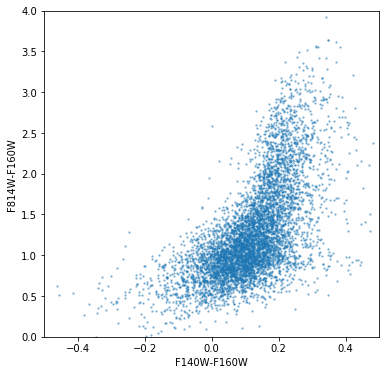

In [53]:
clip = (cat_3dhst['cat'] == '3dhst') & (cat_3dhst['star_flag'] != 1) & (cat_3dhst['use_phot'] == 1)
clip &= (mag(cat_3dhst['f_F140W']) < 24.5) & (mag(cat_3dhst['f_F160W']) < 24.5)  
clip &= (cat_3dhst['z_peak']>1.) & (cat_3dhst['z_peak']<2.5)
clip &= (cat_3dhst['f_F140W'] > 0) & (cat_3dhst['f_F160W'] > 0) & (cat_3dhst['f_F814W'] > 0)
clip &= (cat_3dhst['f_F140W']/cat_3dhst['e_F140W'] > 10) & (cat_3dhst['f_F160W']/cat_3dhst['e_F160W'] > 10) & (cat_3dhst['f_F814W']/cat_3dhst['e_F814W'] > 10)
print(clip.sum())
print(np.median(cat_3dhst['f_F140W'][clip]/cat_3dhst['f_F160W'][clip]))

idx, dr = phot.match_to_catalog_sky(cat_3dhst[clip])
synth_mag = phot[idx[dr.value<0.6]]
phot_mag = cat_3dhst[clip][dr.value<0.6]


#c = (synth_mag['mag_acs,wfc1,f814w'] < 24) & (synth_mag['mag_acs,wfc1,f814w'] > 0)
synth_mag = synth_mag
phot_mag = phot_mag

fig = plt.figure(figsize=[6,6])
plt.scatter(mag(phot_mag['f_F140W'])-mag(phot_mag['f_F160W']),mag(phot_mag['f_F814W'])-mag(phot_mag['f_F160W']),s=2,alpha=0.4)
plt.xlim([-0.5,.5])
plt.ylim([0,4])
plt.xlabel('F140W-F160W')
plt.ylabel('F814W-F160W')
plt.savefig('check_colors.png',dpi=400)

In [100]:
idx, dr = phot.match_to_catalog_sky(cat_3dhst[clip])
synth_mag = phot[idx[dr.value<0.6]]
phot_mag = cat_3dhst[clip][dr.value<0.6]

# Generate Mass model

In [6]:
def empirical_mass2(cat, zout, fout, root='3dhst', mag_band='F140W', mag_ZP=23.9, phot_bands=['F125W', 'F160W'], degree=[5,5,5], clf=None, zshow=1., dq=None, static_fit=None):
    # Color
    blue = cat[phot_bands[0]]
    red = cat[phot_bands[1]]
    phot_color = -2.5*np.log10(np.maximum(np.maximum(blue, 1.e-6)/np.maximum(red, 1.e-6), 1e-6))

    # Magnitude
    hmag = mag_ZP - 2.5*np.log10(np.maximum(cat[mag_band], 1e-4))

    # Input data / output vector
    z = np.maximum(zout['z_peak'].data.data, 0)
    z[~np.isfinite(z)] = 0

    Xfull = np.vstack([np.log(1+z), hmag.data.data, phot_color.data.data]).T
    yobs = fout['lmass']
    # Transform data for polynomial model
    if static_fit is None:
        poly = PolynomialFeatures(np.max(degree))
    else:
        clf, poly, use_powers = static_fit

    X_ = poly.fit_transform(Xfull)

    # DQ selection: stars, etc.
    clip = (cat[mag_band] > 0) & (hmag < 28) & (phot_color < 10) & (phot_color > -10) & np.isfinite(fout['lmass']) & (blue > 0) & (red > 0) & (z > 0.02)

    if dq is not None:
        clip &= dq
    
    if ('star' in cat.colnames) & ('star_flag' in cat.colnames):
        clip &= (((cat['cat'] == 'uvista') & (cat['nan_contam'] == 0) & (cat['contamination'] == 0) & (cat['star'] == 0)) | ((cat['cat'] == '3dhst') & (cat['star_flag'] != 1) & (cat['use_phot'] == 1)))
    
    elif ('star' in cat.colnames) & ('star_flag' not in cat.colnames):
        clip &= (cat['cat'] == 'uvista') & (cat['nan_contam'] == 0) & (cat['contamination'] == 0) & (cat['star'] == 0)
    
    elif ('star' not in cat.colnames) & ('star_flag' in cat.colnames):
        clip &= (cat['cat'] == '3dhst') & (cat['star_flag'] != 1) & (cat['use_phot'] == 1)
        clip &= hmag < 24
        clip &= (z>1.) & (z<2.5)
    
    #fix astropy masking BS
    clip = np.array(clip)
    
    
    ########################
    ### Limit polynomial degree by parameter
    powers = []
    for p in poly.get_feature_names():
        pdict = {}
        for k in p.split():
            if k.startswith('x'):
                i = int(k[1:].split('^')[0])
                if '^' in k:
                    power = int(k.split('^')[1])
                else:
                    power = 1

                pdict[i] = power

        p_i = []
        for i in range(poly.n_input_features_):
            if i in pdict:
                p_i.append(pdict[i])
            else:
                p_i.append(0)

        powers.append(p_i)
        #print(p, p_i)

    if static_fit is None:
        for i in range(poly.n_input_features_):
            if i == 0:
                use_powers = np.array(powers)[:,i] <= degree[i]
            else:
                use_powers &= np.array(powers)[:,i] <= degree[i]

    ######################
    ### Fit the Polynomial model        
    if static_fit is None:
        if clf is None:
            clf = linear_model.LinearRegression()

        clf.fit(X_[clip,:][:,use_powers], yobs[clip])

    y_pred = clf.predict(X_[:,use_powers])
    #######################
    ### Make a figure

    fig = plt.figure(figsize=[9,6])
    # Mass as function of mag / z
    ax = fig.add_subplot(221)
    ax.scatter(zout['z_peak'][clip], hmag[clip], c=yobs[clip], alpha=0.1, cmap=plt.cm.Spectral_r, vmin=8, vmax=12, marker='.')
    ax.set_title('Obs. mass')
    ax.text(0.95, 0.05, r'$N$={0}'.format(clip.sum()), ha='right', va='bottom', transform=ax.transAxes, size=9)
    
    # model mass as function of mag / z
    ax = fig.add_subplot(222)
    ax.scatter(zout['z_peak'][clip], hmag[clip], c=y_pred[clip], alpha=0.1, cmap=plt.cm.Spectral_r, vmin=8, vmax=12, marker='.')
    sc = ax.scatter(-10, -10, c=y_pred[clip][0], alpha=0.9, cmap=plt.cm.Spectral_r, vmin=8, vmax=12, marker='.')
    cb = plt.colorbar(sc)
    cb.set_label(r'$\log M/M_\odot$')

    ax.set_title('Model mass')

    for i, ax in enumerate(fig.axes[:2]):
        ax.set_xlim(1., 2.5)
        ax.set_ylim(18,26)
        if i > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(mag_band + ' mag')

        ax.set_xlabel('z_peak')
        ax.grid()

    ################### 
    #### z ~ 1 relation
    #zshow = 1.
    sel = clip & (np.abs(zout['z_peak'] - zshow) < 0.1)

    ax = fig.add_subplot(223)
    ax.text(0.95, 0.95, 'deg[z,mag,color]={0}'.format(degree), ha='right', va='top', transform=ax.transAxes, size=9)

    ax.text(0.05, 0.05, r'$N$={0}'.format(sel.sum()), ha='left', va='bottom', transform=ax.transAxes, size=9)
    
    vm = np.percentile(phot_color[sel], [10, 90])
    cmap = plt.cm.RdYlBu_r
    ax.scatter(hmag[sel], fout['lmass'][sel], c=phot_color[sel], alpha=0.1, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')

    # Spline Model @ z=1
    for color_i in np.percentile(phot_color[sel], [5, 25, 50, 75, 95]):
        splx = np.arange(17,28,0.05)
        Xz = np.vstack([splx*0+np.log(1+zshow), splx, splx*0+color_i]).T
        Xz_ = poly.fit_transform(Xz)
        y_ = clf.predict(Xz_[:,use_powers])

        c_i = cmap(np.interp(color_i, vm, [0, 1], left=0, right=1))

        ax.plot(splx, y_, color=c_i)

    ax.set_xlim(17.5, 28)
    ax.set_ylim(7, 12); ax.set_ylabel(r'Mass, $z\sim${0:.1f}'.format(zshow)); ax.set_xlabel(mag_band + ' mag')
    ax.grid()

    # Mass residuals
    ax = fig.add_subplot(224)
    ax.scatter(hmag[sel], (yobs - y_pred)[sel], c=phot_color[sel], alpha=0.1, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')
    sc = ax.scatter(-10, -10, c=phot_color[sel][0], alpha=0.9, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')

    # Running median + scatter
    # eazy = https://github.com/gbrammer/eazy-py
    xm, ym, ys, N = eazy.utils.running_median(hmag[sel], fout['lmass'][sel] - y_pred[sel], NBIN=20, use_median=True, use_nmad=True, reverse=False, bins=None)
    ax.errorbar(xm, ym, yerr=ys, color='k', marker='.', alpha=0.6, linestyle='None')

    cb = plt.colorbar(sc)
    cb.set_label('{0} - {1}'.format(phot_bands[0], phot_bands[1]))

    ax.set_xlim(18, 26)
    ax.set_ylim(-1, 1); ax.set_xlabel(r'log(Mass) M$_{\odot}$')
    ax.grid()

    fig.tight_layout(pad=0.3)
    label = '{0}_{1}-{2}_d{3}_z{4:.1f}'.format(mag_band, phot_bands[0], phot_bands[1], ''.join(['{0}'.format(i) for i in degree]), zshow)

    fig.savefig('../figures/'+root+'_mass_{0}.png'.format(label))
    np.save('../model_uvista_interp/'+root+'_mass_{0}.npy'.format(label), [clf, poly, use_powers])
    print('../figures/'+root+'_mass_{0}.png'.format(label))
    print('../model_uvista_interp/'+root+'_mass_{0}.npy'.format(label))
    return fig, label, [clf, poly, use_powers]

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.588736e-20
  overwrite_a=True).T
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


../figures/3dhst_mass_f_F160W_f_F125W-f_F160W_d753_z1.8.png
../model_uvista_interp/3dhst_mass_f_F160W_f_F125W-f_F160W_d753_z1.8.npy


/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.574641e-20
  overwrite_a=True).T


../figures/3dhst_mass_f_F140W_f_F125W-f_F160W_d753_z1.8.png
../model_uvista_interp/3dhst_mass_f_F140W_f_F125W-f_F160W_d753_z1.8.npy


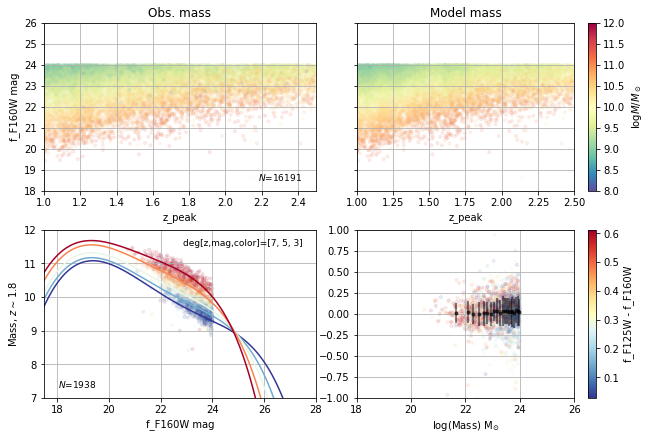

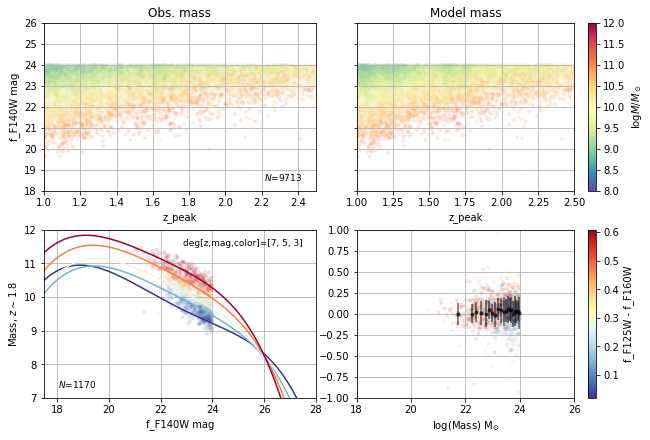

In [7]:
uphot_bands = ['f_F125W', 'f_F160W']
umag_band = 'f_F160W'
zshow = 1.8

degree = [7,5,3]

#clf = linear_model.LinearRegression()

# Use Ridge regressor to constrain high-order parameters and improve
# extrapolation
ridge_alpha = 0.01
clf = linear_model.Ridge(alpha=ridge_alpha)
out = empirical_mass2(cat, zout, fout, mag_band=umag_band, mag_ZP=25, phot_bands=uphot_bands, degree=degree, clf=clf, zshow=zshow, dq=None, root='3dhst')
out = empirical_mass2(cat, zout, fout, mag_band='f_F140W', mag_ZP=25, phot_bands=uphot_bands, degree=degree, clf=clf, zshow=zshow, dq=None, root='3dhst')


# Get color upper and lower bounds

In [8]:
def interpolate_color(cat):
    '''
    Input:
    3dhst catalog
    
    Functionality:
    Take 3dhst full catalog (used to generate models) and 
    calculated the upper and lower bound of color (f125w-f160w)
    for an assortment of redshift bins
    
    Return:
    upper and lower color bound to be interpolated and applied to 
    grism sample
    
    '''
    mag_140 = Column(25 - 2.5*np.log10(np.maximum(cat['f_F140W'], 1e-4)),name = 'mag_F140W')
    mag_160 = Column(25 - 2.5*np.log10(np.maximum(cat['f_F160W'], 1e-4)),name = 'mag_F160W')
    mag_125 = Column(25 - 2.5*np.log10(np.maximum(cat['f_F125W'], 1e-4)),name = 'mag_F125W')
    color = Column((mag_125 - mag_160),name = 'color')
    
    clip = (cat['star_flag'] != 1) & (cat['use_phot'] == 1)
    clip &=  (mag_160 > 0) & (mag_160 < 28) & (mag_125 > 0) & (mag_125 < 28) & np.isfinite(fout['lmass']) & (cat['lmass']>9)
    clip &= (cat['z_peak'] > zmin) & (cat['star_flag'] != 1) & (cat['use_phot'] == 1) & (cat['z_peak']<zmax)

    cat_interp = cat[clip]
    cat_interp.add_column(mag_160[clip], index=0)
    cat_interp.add_column(mag_140[clip], index=0)
    cat_interp.add_column(mag_125[clip], index=0)
    cat_interp.add_column(color[clip], index=0)

    print(len(cat_interp))

    cat_interp['colorf125'] = cat_interp['mag_F125W']
    # Bin uvista data and calculate hmag cut at each bin
    bins = np.arange(1.3,2.55,0.125)
    inds = np.digitize(cat_interp['z_peak'],bins+.125)
    
    color_up = np.zeros(8)
    color_low = np.zeros(8)
    for i in (np.arange(8)):
        zslice = cat_interp[inds==i]
        print(np.median(zslice['z_peak']))
        color_up[i],color_low[i] = np.percentile(zslice['color'],[97,3])

    # Check out the hmag cuts
    print(bins);print(color_up);print(color_low)
    
    plt.scatter(bins[0:8],color_up)
    plt.scatter(bins[0:8],color_low)
    plt.xlabel('z_peak')
    plt.ylabel('color')
    #plt.savefig('../figures/uvista_hmag_cut.png')
    plt.show()
    
    
    return(bins,color_up,color_low)

In [9]:
def mag(flux):
    mag = 25-2.5*np.log10(flux)
    return(mag)

def color(fluxb,fluxr):
    color = -2.5*np.log10(fluxb/fluxr)
    return(color)

In [10]:
ok = (cat_3dhst['use_phot'] == 1)
ok &= cat_3dhst['star_flag'] !=1
ok &= (cat_3dhst['z_peak'] > zmin) & (cat_3dhst['z_peak'] < zmax) & np.isfinite(cat_3dhst['z_peak'])

cat_3dhst_clean = cat_3dhst[ok]
ok.sum()

idx, dr = cat_3dhst_clean.match_to_catalog_sky(grism)
idx = idx[dr.value<0.6]
grism_matched23dhst = grism[(dr.value<0.6)]
hst_matched2grism = cat_3dhst_clean[idx]
len(hst_matched2grism)

2661

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


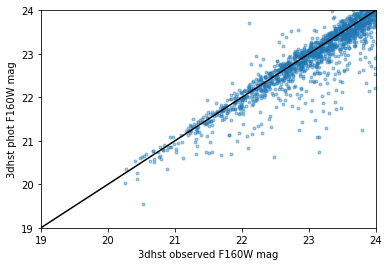

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


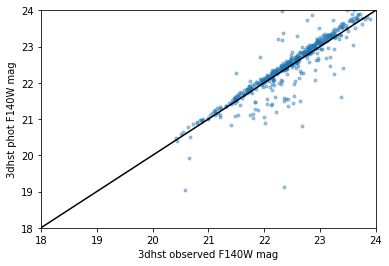

0.05121860560762315 -0.08843281766639777


In [11]:
# Here, find aperture correction for hmags (only include hmag < 24)
mass_cut = 10

apcorr = grism_matched23dhst['flux_auto']/grism_matched23dhst['flux_aper_1']

select = np.isfinite(23.9 - 2.5*np.log10(grism_matched23dhst['f160w_flux_aper_1']*apcorr))
select &= np.isfinite(mag(hst_matched2grism['f_F160W']))
select &= mag(hst_matched2grism['f_F160W'])<24

plt.scatter(mag(hst_matched2grism['f_F160W']),23.9 - 2.5*np.log10(grism_matched23dhst['f160w_flux_aper_1']*apcorr),marker='.',alpha=0.4)
plt.xlabel('3dhst observed F160W mag')
plt.ylabel('3dhst phot F160W mag')
plt.ylim([19,24])
plt.xlim([19,24])
plt.plot([19,24],[19,24],c='k')
plt.show()
offsetf160 = np.median(mag(hst_matched2grism['f_F160W'][select])-(23.9 - 2.5*np.log10(grism_matched23dhst['f160w_flux_aper_1'][select]*apcorr[select])))


select = np.isfinite(23.9 - 2.5*np.log10(grism_matched23dhst['f140w_flux_aper_1']*apcorr))
select &= np.isfinite(mag(hst_matched2grism['f_F140W']))
select &= mag(hst_matched2grism['f_F140W'])<24
select &= hst_matched2grism['lmass'] > mass_cut


plt.scatter(mag(hst_matched2grism['f_F140W'][select]),23.9 - 2.5*np.log10(grism_matched23dhst['f140w_flux_aper_1'][select]*apcorr[select]),marker='.',alpha=0.4)
plt.xlabel('3dhst observed F140W mag')
plt.ylabel('3dhst phot F140W mag')
plt.ylim([18,24])
plt.xlim([18,24])
plt.plot([18,24],[18,24],c='k')
plt.show()
offsetf140 = np.median(mag(hst_matched2grism['f_F140W'][select])-(23.9 - 2.5*np.log10(grism_matched23dhst['f140w_flux_aper_1'][select]*apcorr[select])))

print(offsetf160,offsetf140)

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.04036376245627335


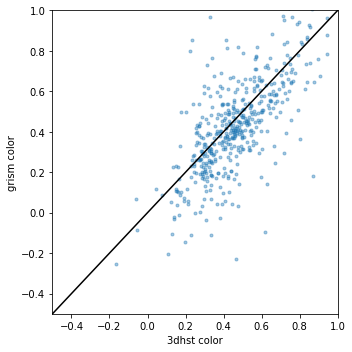

In [12]:
# Here find color correction
fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot(111)
plt.scatter(color(hst_matched2grism[select]['f_F125W'],hst_matched2grism[select]['f_F160W']),grism_matched23dhst['mag_wfc3,ir,f125w'][select]-grism_matched23dhst['mag_wfc3,ir,f160w'][select],marker='.',alpha=0.4)
ax2.set_ylim([-0.5,1])
ax2.set_xlim([-0.5,1])
ax2.plot([-0.5,1],[-0.5,1],c='k')
ax2.set_ylabel('grism color')
ax2.set_xlabel('3dhst color')
offset_color = np.median(color(hst_matched2grism['f_F125W'][select],hst_matched2grism['f_F160W'][select])-(grism_matched23dhst['mag_wfc3,ir,f125w'][select]-grism_matched23dhst['mag_wfc3,ir,f160w'][select]))
plt.tight_layout()
print(offset_color)

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


19872
1.3634


/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


1.49085
1.62
1.7336
1.8606
1.9856500000000001
2.11835
2.2403
[1.3   1.425 1.55  1.675 1.8   1.925 2.05  2.175 2.3   2.425]
[0.66721248 0.68947134 0.61823317 0.65045408 0.75585876 0.86158656
 0.97666505 0.9822448 ]
[ 0.01544784 -0.04441018 -0.2311721  -0.23832263 -0.01594125  0.07142116
  0.0907867   0.12154472]


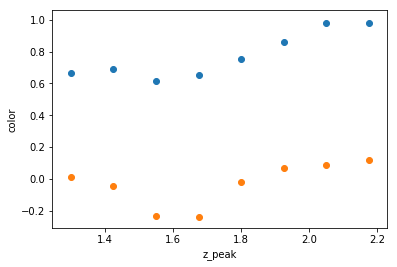

28279
This gets rid of:  9003 galaxies
19276


In [13]:
grism_clip = (grism['chinu']<2) & (np.isfinite(grism['chinu']))
grism_clip &= (grism['bic_diff']>10) & (np.isfinite(grism['bic_diff']))
grism_clip &= (grism['zwidth1']<0.1) & (np.isfinite(grism['zwidth1']))
grism_clip &= np.isfinite(grism['redshift']) &(grism['redshift']>1.) & (grism['redshift'] <2.5)
# Here remove any objects that have more than 10% of pixels masked
sel = np.isfinite(grism['f140w_mask_aper_1'])
npix_aper1 = round(np.max(grism['f140w_mask_aper_1'][sel]))

# This was a pain... had to convert to numpy array or else it would mask funny
frac_masked_f140 = np.array(grism['f140w_mask_aper_1']/npix_aper1)
frac_masked_f160 = np.array(grism['f160w_mask_aper_1']/npix_aper1)

grism_clip &= (np.isfinite(frac_masked_f140) | np.isfinite(frac_masked_f160))
grism_clip &= ((frac_masked_f140 < 0.1) | (frac_masked_f160 < 0.1))



# Call above function
bins_long,color_up,color_low = interpolate_color(cat_3dhst)
bins=bins_long[0:8]
#####################

color_up_interp_cut = np.interp(grism['redshift'], bins, color_up)
color_low_interp_cut = np.interp(grism['redshift'], bins, color_low)

c = grism_clip.sum()
print(c)
grism_clip &= (grism['color']+offset_color > color_low_interp_cut) & (grism['color']+offset_color < color_up_interp_cut)

print('This gets rid of: ',c-grism_clip.sum(),'galaxies')
print(grism_clip.sum())



In [15]:
# How I grab the masses
grism_clean = grism[grism_clip]
#grism_clean = utils.GTable.read('../get_mass_for_comparison2.fits')
apcorr = grism_clean['flux_auto']/grism_clean['flux_aper_1']

def get_mass(redshift, hmag, red, blue, static_fit):
    
    phot_color = blue - red + offset_color
    # Input data / output vector
    z = np.maximum(redshift, 0)

    Xfull = np.vstack([np.log(1+z), hmag, phot_color]).T

    clf, poly, use_powers = static_fit

    X_ = poly.fit_transform(Xfull)
    
    y_pred = clf.predict(X_[:,use_powers])
    
    return y_pred

mass = np.zeros(len(grism_clean))
grism_clean_col = np.zeros(len(grism_clean))
hmag_aliza = np.zeros(len(grism_clean))
hmag_filt = np.zeros(len(grism_clean)).astype('str')
flux = np.zeros(len(grism_clean))

f = np.load('../model_uvista_interp/3dhst_mass_f_F140W_f_F125W-f_F160W_d753_z1.8.npy')
g = np.load('../model_uvista_interp/3dhst_mass_f_F160W_f_F125W-f_F160W_d753_z1.8.npy')


for i in range(len(grism_clean)):
    if (grism_clean['f140w_flux_aper_1'][i] > 0) & np.isfinite(grism_clean['f140w_flux_aper_1'][i]):
        load = f
        hmag = 23.9-2.5*np.log10(grism_clean['f140w_flux_aper_1'][i]*apcorr[i]) + offsetf140
        hmag_aliza[i] = hmag - offsetf140
        hmag_filt[i] = 'f140w'
        flux[i] = grism_clean['f140w_flux_aper_1'][i]*apcorr[i]
    elif (grism_clean['f160w_flux_aper_1'][i] > 0) & np.isfinite(grism_clean['f160w_flux_aper_1'][i]):
        load = g
        hmag = 23.9-2.5*np.log10(grism_clean['f160w_flux_aper_1'][i]*apcorr[i]) + offsetf160
        hmag_aliza[i] = hmag - offsetf160
        hmag_filt[i] = 'f160w'
        flux[i] = grism_clean['f160w_flux_aper_1'][i]*apcorr[i]
    else:
        mass[i] = -99
        hmag_aliza[i] = 100
        hmag_filt[i] = 'Nope'
        continue
    red = grism_clean['mag_wfc3,ir,f160w'][i]
    blue = grism_clean['mag_wfc3,ir,f125w'][i]
    grism_clean_col[i] = blue - red
    try:
        mass[i] = get_mass(redshift = grism_clean['redshift'][i], hmag = hmag, red = red, blue = blue, static_fit=load)
    except:
        mass[i] = -99
grism_clean['mass'] = mass
grism_clean['hmag_aliza'] = hmag_aliza
grism_clean['grism_clean_col'] = grism_clean_col
grism_clean['hmag_filt'] = hmag_filt
grism_clean['flux'] = flux

In [16]:
grism_clean.write('../got_mass_z_1.3_2.3_753.fits',overwrite=True)

In [21]:
grism_clean.write('../complete/full_clean_with_mass.fits',overwrite=True)

1012
236


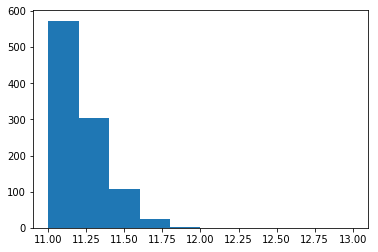

objects with phot flag:  114


In [75]:
plt.hist(grism_clean['mass'],range=[11,13])
sample = (grism_clean['mass'] > 11); print(sample.sum())
sample &= grism_clean['flux_Ha']/grism_clean['err_Ha'] > 5 ; print(sample.sum())
plt.show()

print('objects with phot flag: ',(grism_clean[sample]['flag'] & 1).sum())
grism_clean[sample].write('../complete/prelim_sample_478_obj.fits',overwrite=True)

In [76]:
pre_rate_sample = grism_clean[sample]
(grism_clean[sample]['cat']=='3dhst').sum()

78

In [1252]:
clip = (pre_rate_sample['flag'] & 1).astype('bool')
flagged = pre_rate_sample[clip]
full_file,line_file,stack_file = [],[],[]

for i,table in enumerate(flagged):
    if table['root'][7] =='+':
        sign = '%2B'
    else:
        sign = '-'
    full_file.append('https://s3.amazonaws.com/aws-grivam/Pipeline/{0}{1}{2}/Extractions/{0}{1}{2}_{3:05d}.full.png'.format(table['root'][:7],
                                                                                                              sign,table['root'][8:],table['id']))
    line_file.append('https://s3.amazonaws.com/aws-grivam/Pipeline/{0}{1}{2}/Extractions/{0}{1}{2}_{3:05d}.line.png'.format(table['root'][:7],
                                                                                                              sign,table['root'][8:],table['id']))
    stack_file.append('https://s3.amazonaws.com/aws-grivam/Pipeline/{0}{1}{2}/Extractions/{0}{1}{2}_{3:05d}.stack.png'.format(table['root'][:7],
                                                                                                sign,table['root'][8:],table['id']))
full_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in full_file]
line_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in line_file]
stack_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in stack_file]

# reformat strings

flagged['redshift'].format = '.1f'
flagged['mass'].format = '.1f'
flagged['flag'].format = '.1f' 

flagged['full_png'] = full_url
flagged['line_png'] = line_url
flagged['stack_png'] = stack_url


cut_tab = flagged['root','id','mass','redshift','flag','cat','stack_png','full_png','line_png']

cut_tab.write_sortable_html('check_out_flagged.html', max_lines=10000, 
                            filter_columns=['id','mass'])

!open check_out_flagged.html

In [1223]:
len(keep)

258

In [77]:
# Remove weird looking flagged objects
# 1 means good
# 0 means leave out!
keep = np.array([0,1,0,0,1,0,0,0,1,1,
                    1,1,1,1,0,1,0,1,0,1,
                    0,1,0,0,1,1,0,1,1,0,
                    0,1,1,0,0,0,0,1,1,1,
                    1,1,1,1,1,0,1,1,0,1,
                    
                    0,0,0,1,0,1,0,1,0,0,
                    0,1,1,1,1,0,0,1,0,1,
                    0,1,0,1,1,0,0,1,1,1,
                    0,0,1,1,0,0,1,1,1,1,
                    1,1,0,0,0,0,1,0,1,0,
                    
                    0,1,0,0,1,1,0,1,0,1,
                    1,1,1,0,0,1,0,1,1,0,
                    0,0,0,0,0,0,1,1,0,1,
                    0,1,0,1,1,0,1,1,1,0,
                    1,0,0,1,0,0,0,0,1,1,
                    
                    0,1,1,1,1,1,0,1,1,1,
                    1,1,1,1,1,0,1,1,0,1,
                    1,1,1,0,1,1,1,1,1,1,
                    0,1,1,1,0,1,0,0,1,0,
                    1,0,1,0,1,0,1,1,1,0,
                    
                    0,1,1,1,0,0,1,0,0,1,
                    1,1,0,1,1,1,0,0,0,0,
                    1,1,0,0,1,0,1,1,1,1,
                    0,0,1,0,1,0,0,1,1,1,
                    
                    0,0,1,1,0,1,0,1,0,0,
                    1,1,1,0,0,1,1,0])

keep = keep.astype('bool')

In [78]:
# Now remove the bad flag objects

flagged = (pre_rate_sample['flag'] & 1).astype('bool')
flagged_keep = pre_rate_sample[flagged][keep]
not_flagged = pre_rate_sample[~flagged]
table_post_flag_check = vstack([not_flagged,flagged_keep])
print('the following should be the same: ')
print(len(table_post_flag_check))
print(len(pre_rate_sample)-(~keep).sum())
table_post_flag_check.write('../complete/sample_removed_badflag.fits',overwrite=True)

# Now make segmapssss
# then run that statmorphhhhh using above table


IndexError: boolean index did not match indexed array along dimension 0; dimension is 114 but corresponding boolean dimension is 258

In [1256]:
# Make pretty table of non-flagged objects and
# go through all of them!

tab = utils.GTable.read('../complete/sample_removed_badflag.fits')
complete = utils.GTable.read('../complete/statmorph_sizes_365.fits')

for c in complete.colnames:
    if c.startswith('sci'):
        tab['cont'+c[3:]]=complete[c]
    if c.startswith('line'):
        tab['ha_'+c]=complete[c]
    if c.startswith('fake'):
        tab['fake'+c[3:]]=complete[c]



#cont_rate = np.ones(len(tab)).astype('bool')
#ha_rate = np.ones(len(tab)).astype('bool')

ha_model_file = ['../complete/figures/{0}_{1:05d}.ha-model.png'.format(tab['root'][i], tab['id'][i]) 
                 for i in range(len(tab))]
cont_model_file = ['../complete/figures/{0}_{1:05d}.png'.format(tab['root'][i], tab['id'][i]) 
                 for i in range(len(tab))]
fake_ha_file = ['../complete/figures/{0}_{1:05d}.ha-model.fake.png'.format(tab['root'][i], tab['id'][i]) 
                 for i in range(len(tab))]

full_file,line_file,stack_file = [],[],[]

for i,table in enumerate(tab):
    if table['root'][7] =='+':
        sign = '%2B'
    else:
        sign = '-'
    full_file.append('https://s3.amazonaws.com/aws-grivam/Pipeline/{0}{1}{2}/Extractions/{0}{1}{2}_{3:05d}.full.png'.format(table['root'][:7],
                                                                                                              sign,table['root'][8:],table['id']))
    line_file.append('https://s3.amazonaws.com/aws-grivam/Pipeline/{0}{1}{2}/Extractions/{0}{1}{2}_{3:05d}.line.png'.format(table['root'][:7],
                                                                                                              sign,table['root'][8:],table['id']))
    stack_file.append('https://s3.amazonaws.com/aws-grivam/Pipeline/{0}{1}{2}/Extractions/{0}{1}{2}_{3:05d}.stack.png'.format(table['root'][:7],
                                                                                                sign,table['root'][8:],table['id']))

ha_model_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in ha_model_file]
cont_model_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in cont_model_file]
fake_ha_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in fake_ha_file]
full_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in full_file]
line_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in line_file]
stack_url = ['<a href={0}><img src={0} height=200px></a>'.format(file) for file in stack_file]


# reformat strings
tab['cont_sersic_n'].format = '.1f'
tab['ha_line_sersic_n'].format = '.1f'
tab['redshift'].format = '.1f'
tab['mass'].format = '.1f'
tab['gmass'] = np.log10(tab['stellar_mass'])
tab['gmass'].format = '.1f'
tab['flag'].format = '.1f' 

tab['ha_model_png'] = ha_model_url
tab['cont_model_png'] = cont_model_url
tab['fake_model_png'] = fake_ha_url
tab['full_png'] = full_url
tab['line_png'] = line_url
tab['stack_png'] = stack_url

#tab['cont_rate'] = cont_rate
#tab['ha_rate'] = ha_rate


clip = (cont_rate > 2) & (ha_rate > 2)
cut_tab = tab['root','id','cont_sersic_n','ha_line_sersic_n','mass',
              'ha_line_flag_sersic','redshift','cont_flag_sersic', 'flag',
              'cont_model_png','ha_model_png','fake_model_png','stack_png','full_png','line_png']


cut_tab[clip].write_sortable_html('table.html', max_lines=10000, 
                            filter_columns=['id','cont_sersic_n','ha_sersic_n','ha_flag_sersic','cont_flag_sersic'])
#!open table.html
tab[clip].write('../complete/final_sample_225.fits',overwrite=True)

In [24]:
cont_rate = np.array([4,3,3,4,0,3,4,3,3,4,
                      4,3,4,4,3,4,4,3,4,4,
                      3,0,3,3,3,3,3,3,3,4,
                      3,3,4,4,3,3,3,3,3,4,
                      4,4,4,3,4,4,4,3,3,3,
                      
                      3,4,4,4,3,4,3,3,3,3,
                      3,4,4,3,4,3,3,4,4,4,
                      3,3,3,4,3,3,3,3,4,4,
                      3,3,4,4,4,4,3,4,4,4,
                      4,4,3,3,4,4,4,4,4,4,
                      
                      3,3,3,0,4,3,3,4,3,3,
                      3,3,4,3,4,4,4,3,4,3,
                      3,3,4,3,3,4,4,4,3,3,
                      3,4,4,3,3,4,3,4,3,3,
                      3,4,3,3,3,3,3,3,4,3,
                      
                      4,3,4,4,4,4,3,3,4,4,
                      3,3,4,4,3,4,3,3,4,4,
                      3,4,3,4,0,3,4,4,4,3,
                      4,3,4,3,3,4,4,4,4,3,
                      3,3,0,0,4,4,4,4,4,3,
                      
                      4,3,4,3,4,3,4,3,3,3,
                      3,3,4,4,3,3,4,4,4,3,
                      3,3,3,3,3,4,4,3,4,4,
                      4,4,0,4,3,3,4,4,0,0,
                      3,4,3,3,4,0,3,3,3,3,
                      
                      4,4,4,0,0,0,4,4,4,1,
                      0,3,3,3,3,4,3,3,3,3,
                      3,3,4,4,4,3,3,4,4,3,
                      4,4,4,4,3,3,3,3,0,0,
                      3,3,4,4,4,3,3,3,3,0,
                      
                      3,3,1,3,3,3,4,4,3,3,
                      3,3,3,3,4,4,3,4,4,4,
                      3,4,3,4,4,4,4,4,4,4,
                      3,4,4,4,3,4,3,4,4,4,
                      3,3,4,4,4,4,4,4,4,4,
                      
                      3,0,3,3,3,0,3,4,3,4,
                      4,4,3,4,3])

ha_rate = np.array([3,3,2,4,0,4,3,3,1,4,
                    2,2,1,3,4,3,4,3,1,1,
                    3,0,1,1,3,3,1,3,3,1,
                    1,0,1,1,4,4,1,4,3,1,
                    3,3,4,3,3,4,1,1,3,1,
                    
                    1,3,1,1,3,3,3,3,1,3,
                    3,3,1,3,3,4,1,1,3,0,
                    1,3,1,1,3,3,0,3,3,0,
                    1,3,1,3,1,3,1,3,3,3,
                    1,1,3,4,1,3,3,3,3,1,
                    
                    3,3,3,0,2,3,3,1,1,3,
                    1,1,3,1,1,3,3,3,3,4,
                    3,3,3,1,4,1,3,3,3,1,
                    4,3,1,4,4,4,4,4,4,4,
                    3,4,4,4,1,1,1,1,3,3,
                    
                    2,3,1,3,3,1,3,4,1,3,
                    1,1,1,1,3,1,1,3,1,3,
                    4,1,1,3,0,3,1,3,1,1,
                    4,4,3,3,3,4,3,3,4,3,
                    3,3,0,0,1,3,3,3,1,3,
                    
                    3,4,3,3,1,1,1,4,3,3,
                    3,3,3,1,3,1,1,3,1,1,
                    1,3,3,3,3,1,1,3,1,1,
                    1,1,0,3,4,3,4,1,0,0,
                    4,1,-99,3,1,1,1,-99,3,3,
                    
                    3,4,1,0,0,0,3,4,3,3,
                    0,3,1,3,2,1,4,3,3,1,
                    3,3,3,3,3,3,1,1,1,4,
                    4,4,3,1,3,3,1,3,0,0,
                    4,4,1,3,4,3,3,3,1,0,
                    
                    3,3,0,1,4,4,4,4,4,4,
                    4,4,1,4,4,4,4,4,4,4,
                    4,3,3,3,3,1,3,3,4,4,
                    3,3,4,3,4,3,3,3,1,1,
                    1,4,4,4,1,1,1,3,4,4,
                    
                    4,0,3,3,3,0,1,1,1,3,
                    3,3,3,3,3])

agn = np.array([1,0,0,0,0,0,0,0,1,0,
                1,0,0,1,0,0,0,1,0,0,
                0,0,0,0,0,1,0,0,0,1,
                1,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,1,0,1,
                
                0,0,0,0,0,0,0,0,0,0,
                0,1,0,0,0,0,1,0,0,0,
                0,0,1,1,1,0,0,1,1,0,
                0,0,1,0,1,0,0,0,0,1,
                1,1,1,0,0,0,0,0,0,0,
                
                0,0,1,0,0,0,0,0,0,0,
                0,0,0,1,0,0,0,0,0,0,
                0,0,0,0,0,0,1,0,0,0,
                0,1,1,0,0,0,0,0,0,0,
                0,0,0,0,1,0,1,0,0,0,
                
                1,0,0,0,1,0,0,0,0,0,
                0,0,0,0,0,1,1,0,1,0,
                0,0,0,0,0,0,0,0,0,0,
                1,1,1,0,0,0,1,1,0,0,
                0,0,0,0,1,1,1,1,1,0,
                
                1,0,1,1,1,0,0,0,1,0,
                0,0,1,1,1,1,1,0,1,0,
                1,0,0,0,0,1,1,0,1,0,
                0,0,0,0,0,0,0,0,0,0,
                0,1,0,0,0,0,0,0,0,0,
                
                0,0,1,0,0,0,1,0,0,0,
                0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,
                1,1,0,0,1,0,1,0,0,0,
                0,0,0,0,0,0,0,0,0,0,
                
                0,0,0,0,0,0,1,0,0,0,
                0,0,0,0,0,0,0,0,0,1,
                0,0,0,0,1,1,1,0,0,1,
                0,0,0,0,0,0,0,0,0,0,
                1,0,0,1,1,1,0,0,0,0,
                
                0,0,0,0,0,0,0,0,1,1,
                0,1,0,1,0])

reduce_further = np.array([0,1,0,1,1,0,1,1,0,1,
                           1,0,0,0,0,0,0,1,1,0,
                           0,0,1,1,1,1,1,1,1,0,
                           1,0,1,0,1,0,0,1,1,1,
                           1,0,1,0,1,1,1,1,0,1,
                           
                           0,0,1,1,0,1,0,1,0,0,
                           1,1,1,0,1,1,1,1,1,1,
                           1,1,1,0,0,0,1,0,1,1,
                           1,1,1,1,1,1,1,1,1,0,
                           1,1,1,1,0,1,0,1,1,1,
                           
                           1,0,1,0,1,1,0,0,1,1,
                           1,1,1,1,0,1,0,1,0,1,
                           0,1,1,1,1,0,0,1,0,0,
                           0,0,1,1,0,1,0,0,1,1,
                           1,1,1,1,0,1,1,0,0,0,
                           
                           1,1,1,0,1,1,1,1,1,0,
                           0,1,0,1,0,1,1,1,1,1,
                           1,0,0,1,1,0,1,1,0,1,
                           0,0,1,1,1,0,1,1,1,1,
                           1,1,1,1,0,1,0,1,1,1,
                           
                           1,1,0,1,1,1,0,1,0,1,
                           1,1,0,1,0,1,1,1,0,0,
                           0,0,1,1,0]).astype('bool')

# Analysis time
First, reproduce vdw fig 5 z=1.25 (size/mass) with 3d-hst catalogs

In [4]:
# Get vdw table 
vdw = utils.GTable.read('../galfit_measurements/master_galfit.fits')


# Compile photometric catalog for 3dhst
version = 'v4.1'

cats = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
cat = vstack(cats)

zouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.zout'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
zout = vstack(zouts)

fouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Fast/{0}_3dhst.{1}.fout'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
fout = vstack(fouts)

colors = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/RF_colors/{0}_3dhst.{1}.master.RF'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
color = vstack(colors)

cat_3dhst = hstack([cat,zout,fout,color])


# lengths
print(len(vdw), len(cat_3dhst))


#match catalogs
idx, dr = cat_3dhst.match_to_catalog_sky(vdw)
cat_3dhst = cat_3dhst[idx]

# This is vdw catalog with corresponding photometry, redshifts, masses
master_3dhst = hstack([vdw,cat_3dhst])

119181 207967


In [134]:
# Make cuts from vdw2014 paper
# Mass: M* > 10^9.2
# H(f160w) < 24.5
# Galfit f < 3
# Redshift: 0.7 < z < 1.5
master_3dhst['kpcperarc'] = Planck15.kpc_proper_per_arcmin(master_3dhst['z_peak']).to(u.kpc/u.arcsec)
master_3dhst['u-v'] = -2.5*np.log10(master_3dhst['L153']/master_3dhst['L155'])
master_3dhst['v-j'] = -2.5*np.log10(master_3dhst['L155']/master_3dhst['L161'])

clip = master_3dhst['use_phot'] == 1
clip = master_3dhst['lmass'] > 9
clip &= (25-2.5*np.log10(master_3dhst['f_F160W'])) < 24
clip &= master_3dhst['f'] < 3
clip &= (master_3dhst['z_peak'] > 0.7) & (master_3dhst['z_peak'] < 1.5)


sample_3dhst = master_3dhst[clip]

clip.sum()

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/lib/function_base.py:2831: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


9545

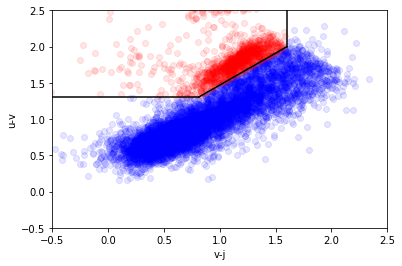

In [135]:
# Determine what is star forming and what is not. Plot it.
# values taken from Kate's paper (2011)

# True means sf, False means passive
sf = np.ones(len(sample_3dhst)).astype('bool')

for i,row in enumerate(sample_3dhst):
    if (row['v-j']<=1.6) & (row['v-j']>0.81):
        lim = 0.88*row['v-j']+0.59
        if row['u-v'] > lim:
            sf[i] = False
    elif (row['v-j'] <= 0.81):
        if row['u-v'] > 1.3:
            sf[i] = False
            
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(sample_3dhst['v-j'][sf],sample_3dhst['u-v'][sf],alpha=0.1,c='b')
ax.scatter(sample_3dhst['v-j'][~sf],sample_3dhst['u-v'][~sf],alpha=0.1,c='r')
ax.set_ylim([-0.5,2.5])
ax.set_xlim([-0.5,2.5])
x1 = np.linspace(-0.5,0.81)
y1 = 1.3*np.ones(len(x1))
x2 = np.linspace(0.81,1.6)
y2 = 0.88*x2+0.59
y3 = np.linspace(2,2.5)
x3 = 1.6*np.ones(len(y3))
ax.plot(x1,y1,c='k')
ax.plot(x2,y2,c='k')
ax.plot(x3,y3,c='k')
ax.set_xlabel('v-j')
ax.set_ylabel('u-v')
plt.show()

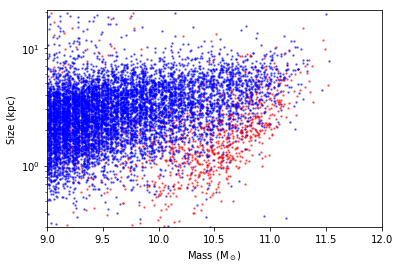

In [136]:
plt.scatter(sample_3dhst['lmass'][~sf],sample_3dhst['re'][~sf]*sample_3dhst['kpcperarc'][~sf],alpha=0.5,c='r',s=2)
plt.scatter(sample_3dhst['lmass'][sf],sample_3dhst['re'][sf]*sample_3dhst['kpcperarc'][sf],alpha=0.5,c='b',s=2)
plt.semilogy()
plt.ylim([0.3,21])
plt.xlim([9,12])
plt.xlabel('Mass (M${_\odot}$)')
plt.ylabel('Size (kpc)')
plt.show()

# Get actual size (convert pixels to kpc)
Use statmorph's rhalf_ellip

In [137]:
# # physical scale
sample = utils.GTable.read('../complete/final_sample_225.fits')

ha_convert = np.zeros(len(sample))
# # convert pixels to arcseconds... Then arcseconds
# # to kpc...
arcperpix = np.zeros(len(sample))
for i,row in enumerate(sample):
    im = fits.open('../complete/full/{0}_{1:05d}.full.fits'.format(row['root'],row['id']))
    convert = im['DSCI'].header['CD2_2']
    ha_convert[i] = im['Line','Ha'].header['CD2_2']*3600
    arcperpix[i] = convert*3600

z = sample['redshift']
kpcperarc = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
sample['cont_size_kpc'] = sample['cont_rhalf_ellip']*arcperpix*kpcperarc
sample['ha_line_size_kpc'] = sample['ha_line_rhalf_ellip']*arcperpix*kpcperarc
sample['fakee_size_kpc'] = sample['fakee_rhalf_ellip']*arcperpix*kpcperarc
sample['kpcperarc'] = kpcperarc
sample['pixel_size'] = arcperpix
AGN = agn[((cont_rate>2) & (ha_rate>2)).astype('bool')].astype('bool')
sample['agn'] = AGN

sample.write('../complete/final_sample_225.fits',overwrite=True)
sample[reduce_further].write('../complete/final_sample_{0}.fits'.format(reduce_further.sum()),overwrite=True)
print(len(sample[reduce_further]))

NameError: name 'agn' is not defined

In [ ]:
print(len(sample[reduce_further]))

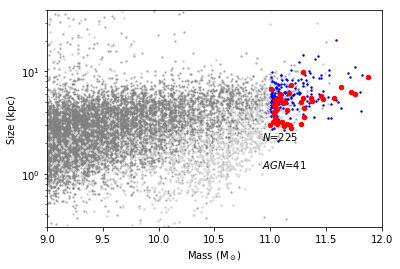

In [35]:

plt.scatter(sample_3dhst['lmass'][sf],sample_3dhst['re'][sf]*sample_3dhst['kpcperarc'][sf],c='gray',alpha=0.5,s=2)
plt.scatter(sample_3dhst['lmass'][~sf],sample_3dhst['re'][~sf]*sample_3dhst['kpcperarc'][~sf],c='lightgray',s=2)

tab = utils.GTable.read('../complete/final_sample_225.fits')

plt.scatter(tab['mass'],tab['cont_size_kpc'],c='b',s=2)
AGN = agn[((cont_rate>2) & (ha_rate>2)).astype('bool')].astype('bool')
plt.scatter(tab['mass'][AGN],tab['cont_size_kpc'][AGN],s=20,c='r',marker = 'o')
#plt.scatter(vdw_3dhst['lmass'],vdw_3dhst['re']*vdw_3dhst['kpcperarc'],s=20,c='limegreen',marker = 'o')
plt.text(0.7,0.3,r'$N$={0}'.format(len(tab)),ha='left', va='bottom', transform=ax.transAxes, size=10)
plt.text(0.7,0.2,r'$AGN$={0}'.format(AGN.sum()),ha='left', va='bottom', transform=ax.transAxes, size=10)


tab_match
plt.semilogy()
plt.ylim([0.3,40])
plt.xlim([9,12])
plt.xlabel('Mass (M${_\odot}$)')
plt.ylabel('Size (kpc)')
plt.savefig('../complete/final_sample_mass_size.png',dpi=400,overwrite=True)
plt.show()

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


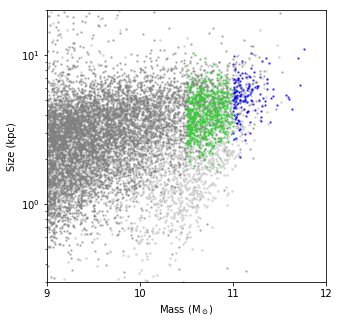

In [140]:
from matplotlib.ticker import MaxNLocator
lower = utils.GTable.read('../complete_10.5/final_sample.fits')

fig = plt.figure(figsize=[5,5])

ax = fig.add_subplot(111)

ax.scatter(sample_3dhst['lmass'][sf],sample_3dhst['re'][sf]*sample_3dhst['kpcperarc'][sf],c='gray',alpha=0.5,s=2)
ax.scatter(sample_3dhst['lmass'][~sf],sample_3dhst['re'][~sf]*sample_3dhst['kpcperarc'][~sf],c='lightgray',s=2)

tab = utils.GTable.read('../complete/final_sample_145.fits')

ax.scatter(tab['mass'],tab['cont_size_kpc'],c='b',s=2,alpha=0.6)
#ax.scatter(tab['mass'][tab['hmag_filt']=='f160w'],tab['cont_size_kpc'][tab['hmag_filt']=='f160w'],c='b',s=2)
#ax.scatter(tab['mass'][tab['hmag_filt']=='f140w'],tab['cont_size_kpc'][tab['hmag_filt']=='f140w'],c='r',s=2)
#AGN = (tab['agn'] ==1)
#ax.scatter(tab['mass'][AGN],tab['cont_size_kpc'][AGN],s=30,c='b',marker = '*')
ax.scatter(lower['mass'],lower['cont_size_kpc'],c='limegreen',s=2,alpha=0.6)

#ax.scatter(vdw_3dhst['lmass'],vdw_3dhst['re']*vdw_3dhst['kpcperarc'],s=20,c='limegreen',marker = 'o')
#ax.text(1.3,.3,r'$N$={0}'.format(len(tab)),ha='left', va='bottom', transform=ax.transAxes, size=10)
#ax.text(1.3,.2,r'$AGN$={0}'.format(AGN.sum()),ha='left', va='bottom', transform=ax.transAxes, size=10)


ax.semilogy()
ax.set_ylim([0.3,20])
ax.set_xlim([9,12])
ax.set_xlabel('Mass (M${_\odot}$)')
ax.set_ylabel('Size (kpc)')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.savefig('../complete/final_sample_mass_size.png',dpi=400,overwrite=True)
fig.show()

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


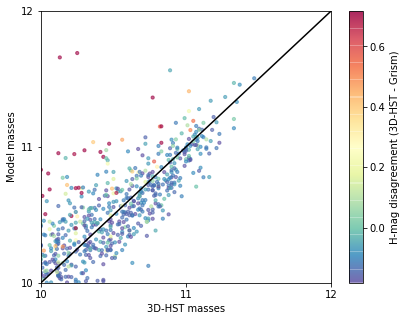

In [33]:
# As a double checker, match vdw gals with gals chosen to be > 10. Calculate how many are missed.
from matplotlib.ticker import MaxNLocator
t = utils.GTable.read('../complete/sample_gt10.fits')
#t = utils.GTable.read('../complete/final_sample_148.fits')

#match them...
sample_3dhst['ra'] = sample_3dhst['ra_1']
sample_3dhst['dec'] = sample_3dhst['dec_1']
idx, dr = sample_3dhst.match_to_catalog_sky(t)
new_idx = idx[dr.value<0.6]

tab_match = t[dr.value<0.6]
vdw_3dhst = sample_3dhst[new_idx]

flagg = (tab_match['flag']&1).astype('bool')

fig = plt.figure(figsize=[6.5,5])
ax = fig.add_subplot(111)
apcorr = tab_match['flux_auto']/tab_match['flux_aper_1']
compare_flux = mag(vdw_3dhst['f_F140W'])-(23.9 - 2.5*np.log10(tab_match['f140w_flux_aper_1']*apcorr))
compare_flux = compare_flux + offsetf140
sc = ax.scatter(vdw_3dhst['lmass'],tab_match['mass'],alpha=0.6,s=10,c=compare_flux,cmap = plt.cm.Spectral_r,vmin=np.percentile(compare_flux,10),vmax=np.percentile(compare_flux,90))

cb = plt.colorbar(sc)
cb.set_label('H-mag disagreement (3D-HST - Grism)')
#ax.scatter(vdw_3dhst['lmass'][flagg],tab_match['mass'][flagg],s=5)
ax.set_xlim([10,12])
ax.set_ylim([10,12])
ax.plot([10,12],[10,12],c='k')
#ax.vlines(11,10,11,linestyle='dashed')
#ax.hlines(11,11,12,linestyle='dashed')
ax.set_xlabel('3D-HST masses')
ax.set_ylabel('Model masses')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.text(0.7,0.2,'These are missed. \nN = {0}'.format(((vdw_3dhst['lmass']>11) & (tab_match['mass']<11)).sum()),ha='left', va='bottom', transform=ax.transAxes, size=10)
fig.savefig('../complete/Compare_masses.png',dpi=400,overwrite=True)
fig.show()

In [839]:
!open ../complete/final_sample_mass_size.png

# Do some analysis

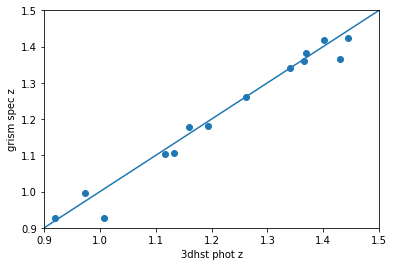

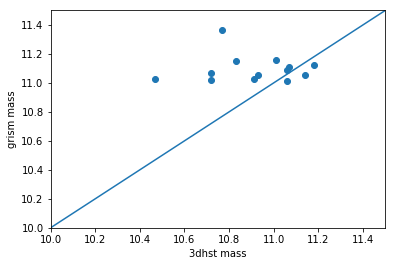

In [859]:
plt.scatter(vdw_3dhst['z_peak'],tab_match['redshift'])
plt.xlabel('3dhst phot z')
plt.ylabel('grism spec z')
plt.xlim([0.9,1.5])
plt.ylim([0.9,1.5])
plt.plot([0.9,1.5],[0.9,1.5])
plt.savefig('../complete/compare_redshifts.png',dpi=200,overwrite=True)
plt.show()

plt.scatter(vdw_3dhst['lmass'],tab_match['mass'])
plt.xlabel('3dhst mass')
plt.ylabel('grism mass')
plt.xlim([10,11.5])
plt.ylim([10,11.5])
plt.plot([10,11.5],[10,11.5])

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


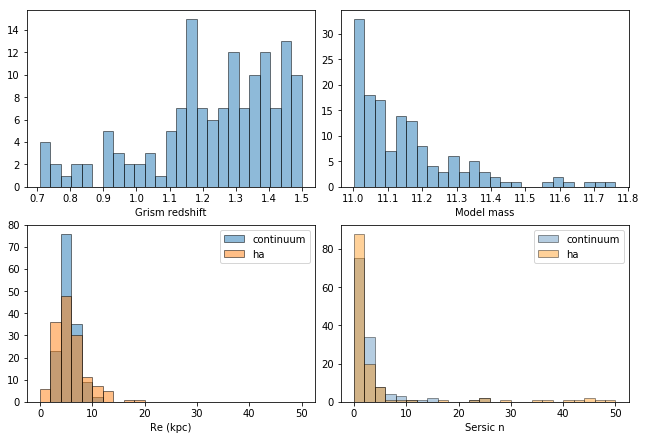

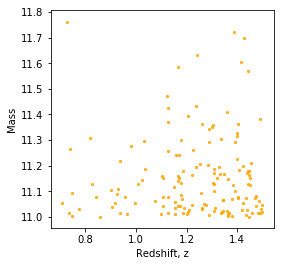

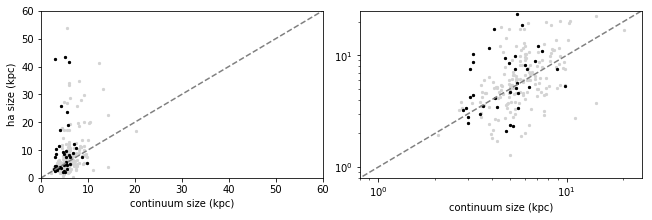

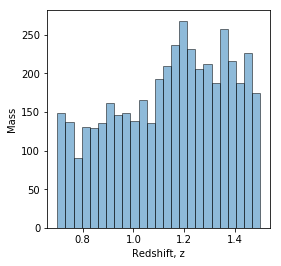

In [847]:
# Let's make some histograms

# read in table:
complete = utils.GTable.read('../complete/final_sample_225.fits')
reduced = utils.GTable.read('../complete/final_sample_148.fits')

# redshift histogram
fig = plt.figure(figsize=[9,6])
#fig.suptitle('Histograms of redshift and mass')
ax = fig.add_subplot(221)
ax.hist(reduced['redshift'],alpha = 0.5,bins=25,edgecolor='k')
ax.set_xlabel('Grism redshift')

# mass histogram
ax2 = fig.add_subplot(222)
ax2.hist(reduced['mass'],alpha = 0.5,bins=25,edgecolor='k')
ax2.set_xlabel('Model mass')

# mass histogram
ax3 = fig.add_subplot(223)
ax3.hist(reduced['cont_size_kpc'],alpha = 0.5,bins=25,range=[0,50],edgecolor='k',label='continuum')
ax3.hist(reduced['ha_line_size_kpc'],alpha = 0.5,bins=25,range=[0,50],edgecolor='k',label='ha')
ax3.legend()
ax3.set_xlabel('Re (kpc)')

ax4 = fig.add_subplot(224)
ax4.hist(reduced['cont_sersic_n'],alpha = 0.4,bins=25,range=[0,50],edgecolor='k',color='steelblue',label='continuum')
ax4.hist(reduced['ha_line_sersic_n'],alpha = 0.4,bins=25,range=[0,50],edgecolor='k',color='darkorange',label='ha')
ax4.legend()
ax4.set_xlabel('Sersic n')

fig.tight_layout(pad=0.3)
fig.show()

# now mass vs redshift
fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.scatter(complete['redshift'][reduce_further],complete['mass'][reduce_further],s=5,c='orange',alpha=0.8)
ax.set_xlabel('Redshift, z')
ax.set_ylabel('Mass')
fig.show()


# Make a scatter plot: Ha vs continuum

fig = plt.figure(figsize=[9,3])
#fig.suptitle('Scatter plots')
ax = fig.add_subplot(121)
ax.scatter(complete['cont_size_kpc'],complete['ha_line_size_kpc'],s=5,c='lightgray',marker='o')
ax.scatter(complete['cont_size_kpc'][complete['agn']==1],complete['ha_line_size_kpc'][complete['agn']==1],s=5,c='black',marker='o')
ax.set_xlabel('continuum size (kpc)')
ax.set_ylabel('ha size (kpc)')
ax.set_xlim([0,60])
ax.set_ylim([0,60])
ax.plot([0,60],[0,60],c='gray',linestyle='dashed')
#ax.loglog()

ax2 = fig.add_subplot(122)
ax2.scatter(complete['cont_size_kpc'],complete['ha_line_size_kpc'],s=5,c='lightgray')
ax2.scatter(complete['cont_size_kpc'][complete['agn']==1],complete['ha_line_size_kpc'][complete['agn']==1],s=5,c='black')
ax2.set_xlabel('continuum size (kpc)')
ax2.set_xlim([0.8,25])
ax2.set_ylim([0.8,25])
ax2.plot([0,60],[0,60],c='gray',linestyle='dashed')
ax2.loglog()

fig.tight_layout(pad=0.5)
fig.show()

# So the redshift distribution looks wrong. Let's
# see what it looked like before Ha cut:

# now mass vs redshift

check_redshift = Table.read('../complete/prelim_sample_gt10.fits')
fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.hist(check_redshift['redshift'],alpha = 0.5,bins=25,edgecolor='k')
ax.set_xlabel('Redshift, z')
ax.set_ylabel('Mass')
fig.savefig('../complete/redshift_hist_gt10.png',dpi=400,overwrite=True)
fig.show()




In [597]:
complete[complete['ha_line_size_kpc']>20]['root','id','cont_size_kpc','ha_line_size_kpc']
complete[(complete['root']=='j094438-194113') & (complete['id']==172)]['root','id','cont_size_kpc','ha_line_size_kpc']



root,id,cont_size_kpc,ha_line_size_kpc
bytes14,int64,float64,float64
j094438-194113,172,4.2551706577616715,5.114230739780329


# Statmorph quantities
- Gini Coefficient:
    - Lorenz curve. As a function of the percentage of the poorest citizens (faintest pixels).
    - Gini coefficient is the ratio of area between Lorenz curve and the curve of "uniform equality"
    - In a completely egalitarian society (uniform pixels), G is zero. If one individual (pixel) has all the wealth, G is 1.
    - Different than C:
        - highly concentrated galaxies have light in small number of pixels. High G arises still when these pixels are not found in center of bulge (C still low)
        
- M20 (Second order moment of brightness):
    - Mtot is flux in each pixel multiplied by the distance squared to the center of the galaxy. Summed over all pixels in segmentation map.
    - Second order is this but with only 20% of brightest (bars, bulges, SF clusters)
    - Very much weighted by distance of pixels from center (bc it's squared)
    - Unlike C, M20 not measured within circular or elliptical apertures, and center is a free parameter. This makes m20 more sensitive to merger signatures
    
- Concentration:
    - Ratio of light within an inner aperture to the light within an outer aperture (like 20% and 80% of light)
    - Center determined by Asymmetry minimization (Below)
    
- Asymmetry:
    - Degree to which the light is rotationally symmetric. Subtract image ratated 180 degrees from original. central pixel is determined by minimizing A.

- Smoothness
    - Quantifies the degree of small-scale structure. Image is smoothed by boxcar and then subtracted from original image. 
    - The residual is a measure of clumpiness (like compact star clusters)
    - Smoothing scale length is chosen to be a fraction of Petrosian (usually 0.25 Rpetro)
    - A is the sum over everything within 1.5 Rpetro and outside of 0.25 Rpetro (because center is super concentrated)


/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


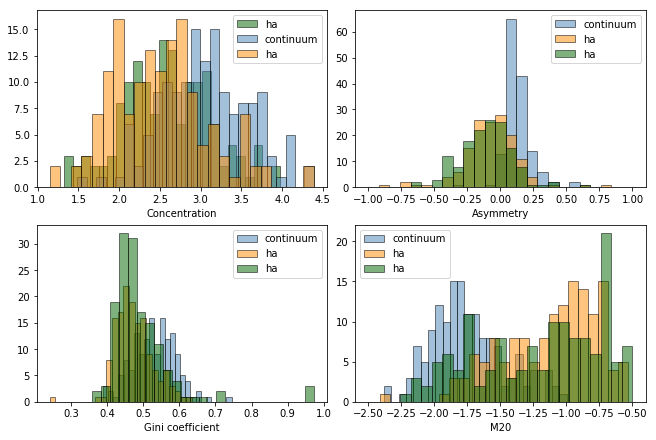

In [658]:
# Do some statmorph quants
fig = plt.figure(figsize=[9,6])

ax = fig.add_subplot(221)
ax.hist(reduced['fakee_concentration'],alpha = 0.5,bins=25,edgecolor='k',label='ha',color='darkgreen')
ax.hist(reduced['cont_concentration'],alpha = 0.5,bins=25,edgecolor='k',label='continuum',color='steelblue')
ax.hist(reduced['ha_line_concentration'],alpha = 0.5,bins=25,edgecolor='k',label='ha',color='darkorange')
ax.legend()
ax.set_xlabel('Concentration')

ax1 = fig.add_subplot(222)
ax1.hist(reduced['cont_asymmetry'],alpha = 0.5,bins=25,edgecolor='k',label='continuum',color='steelblue',range=[-1,1])
ax1.hist(reduced['ha_line_asymmetry'],alpha = 0.5,bins=25,edgecolor='k',label='ha',color='darkorange',range=[-1,1])
ax1.hist(reduced['fakee_asymmetry'],alpha = 0.5,bins=25,edgecolor='k',label='ha',color='darkgreen',range=[-1,1])
ax1.legend()
ax1.set_xlabel('Asymmetry')

ax2 = fig.add_subplot(223)
ax2.hist(reduced['cont_gini'],alpha = 0.5,bins=25,edgecolor='k',label='continuum',color='steelblue')
ax2.hist(reduced['ha_line_gini'],alpha = 0.5,bins=25,edgecolor='k',label='ha',color='darkorange')
ax2.hist(reduced['fakee_gini'],alpha = 0.5,bins=25,edgecolor='k',label='ha',color='darkgreen')
ax2.legend()
ax2.set_xlabel('Gini coefficient')

ax3 = fig.add_subplot(224)
ax3.hist(reduced['cont_m20'],alpha = 0.5,bins=25,edgecolor='k',label='continuum',color='steelblue')
ax3.hist(reduced['ha_line_m20'],alpha = 0.5,bins=25,edgecolor='k',label='ha',color='darkorange')
ax3.hist(reduced['fakee_m20'],alpha = 0.5,bins=25,edgecolor='k',label='ha',color='darkgreen',range=[-2.5,-.5])
ax3.legend()
ax3.set_xlabel('M20')

fig.tight_layout(pad=0.3)
fig.show()

In [782]:
reduce_further.sum()

145

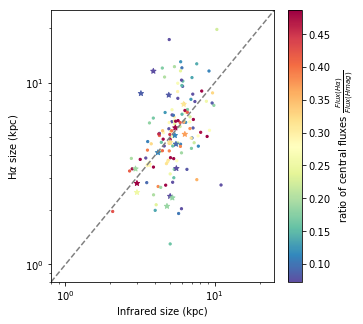

In [1070]:
reduced = utils.GTable.read('../complete/final_sample_145.fits')
ew = reduced['ew50_Ha'] > 100

fig = plt.figure(figsize=[5,5])
ax1 = fig.add_subplot(111)
sc = ax1.scatter(reduced['cont_size_kpc'],reduced['ha_line_size_kpc'],s=5,c=reduced['ratiof'],cmap = plt.cm.Spectral_r,vmin=np.percentile(reduced['ratiof'],10),vmax=np.percentile(reduced['ratiof'],90))
ax1.scatter(reduced['cont_size_kpc'][(reduced['agn']==1)],reduced['ha_line_size_kpc'][(reduced['agn']==1)],s=30,c=reduced['ratiof'][(reduced['agn']==1)],cmap = plt.cm.Spectral_r,vmin=np.percentile(reduced['ratiof'],10),vmax=np.percentile(reduced['ratiof'],90),marker='*')

cb = plt.colorbar(sc)
cb.set_label(r'ratio of central fluxes $\frac{Flux(H\alpha)}{Flux(Hmag)}$')

ax1.set_xlabel('Infrared size (kpc)')
ax1.set_ylabel(r'H$\alpha$ size (kpc)')
#ax1.set_title('All Galaxies')
ax1.set_xlim([0.8,25])
ax1.set_ylim([0.8,25])
ax1.plot([0,25],[0,25],c='gray',linestyle='dashed')
ax1.loglog()

#cut on ew
# ax2 = fig.add_subplot(122)
# ax2.scatter(reduced['cont_size_kpc'][ew],reduced['ha_line_size_kpc'][ew],s=5,c='silver')
# ax2.scatter(reduced['cont_size_kpc'][(reduced['agn']==1) & (ew)],reduced['ha_line_size_kpc'][(reduced['agn']==1) & (ew)],s=5,c='black')
# ax2.set_xlabel('Infrared size (kpc)')
# ax2.set_title(r'Galaxies with EW(H$\alpha$) > 100')
# ax2.set_xlim([0.8,25])
# ax2.set_ylim([0.8,25])
# ax2.plot([0,20],[0,20],c='gray',linestyle='dashed')
# ax2.loglog()
# fig.tight_layout(pad=0.3)

fig.savefig('../complete/size_comparison.png',dpi=400,overwrite=True)

In [1298]:
# 3kpc aperture (ratio of fluxes - ha/cont)
# compute error bars. 

#samp = utils.GTable.read('../complete/final_sample_145.fits')

ratio = np.zeros(len(samp))
ratio_err = np.zeros(len(samp))
contf = np.zeros(len(samp))
err_contf = np.zeros(len(samp))
linef = np.zeros(len(samp))
err_linef = np.zeros(len(samp))
cont_flux = np.zeros(len(samp))
line_flux = np.zeros(len(samp))
cont_flux_err = np.zeros(len(samp))
line_flux_err = np.zeros(len(samp))

for i,tab in enumerate(samp):#[samp['linef_3kpc']/samp['line_flux']> 1]):
    # load images (cont and line)
    full = fits.open('../complete/full/{0}_{1:05d}.full.fits'.format(tab['root'],tab['id']))
    cont = full['DSCI'].data
    cont_err = 1./(full['DWHT'].data)
    segmap = fits.open('../complete/segmap/{0}_{1:05d}.seg.fits'.format(tab['root'],tab['id']))[0].data
    mask_seg = (segmap == tab['id'])
    
    line = full['LINE','Ha'].data
    line_err = 1./(full['LINEWHT','Ha'].data)
    
    # Define centers of images
    contx0 = tab['cont_xc_centroid']
    conty0 = tab['cont_yc_centroid']

    #calculate distance of each pixel in image from center
    yp,xp = np.indices(cont.shape)
    R = np.sqrt((xp-contx0)**2+(yp-conty0)**2)
    aper = R*tab['pixel_size']*tab['kpcperarc'] < 3  # radius to be less than 3kpc
    
    aper_cont = aper & np.isfinite(cont_err)
    segmap_cont = mask_seg & np.isfinite(cont_err)
    contf[i] = np.sum(cont[aper_cont]) #3kpc
    cont_flux[i] = np.sum(cont[segmap_cont]) #full segmap
    err_contf[i] = np.sqrt(np.sum(cont_err[aper_cont & np.isfinite(cont_err)]))
    cont_flux_err[i] = np.sqrt(np.sum(cont_err[segmap_cont & np.isfinite(cont_err)]))
    
    
    aper_line = aper & np.isfinite(line_err)
    segmap_line = mask_seg & np.isfinite(line_err)
    linef[i] = np.sum(line[aper_line]) #3kpc
    err_linef[i] = np.sqrt(np.sum(line_err[aper_line & np.isfinite(line_err)]))
    line_flux[i] = np.sum(line[segmap_line]) #full segmap
    line_flux_err[i] = np.sqrt(np.sum(line_err[segmap_line & np.isfinite(line_err)]))
    
#     plt.imshow(segmap_line*line)
#     plt.show()
#     plt.imshow(aper_line*line)
#     plt.show()

    ratio[i] = linef[i]/contf[i]
    pre_err = ((1./contf[i])*(err_linef[i]))**2+((linef[i]/contf[i]**2)*(err_contf[i]))**2
    ratio_err[i] = np.sqrt(pre_err)

samp['ratiof'] = ratio
samp['ratiof_err'] = ratio_err
samp['contf_3kpc'] = contf
samp['err_contf_3kpc'] = err_contf
samp['linef_3kpc'] = linef
samp['err_linef_3kpc'] = err_linef
samp['cont_flux'] = cont_flux
samp['line_flux'] = line_flux
samp['cont_flux_err'] = cont_flux_err
samp['line_flux_err'] = line_flux_err

samp.write('../complete/final_sample_145.fits',overwrite=True)

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Text(0,0.5,'Flux ratios')

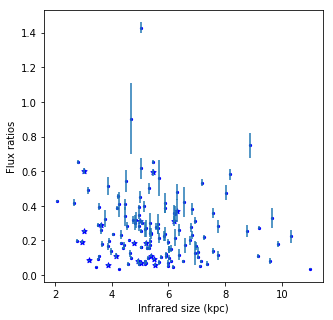

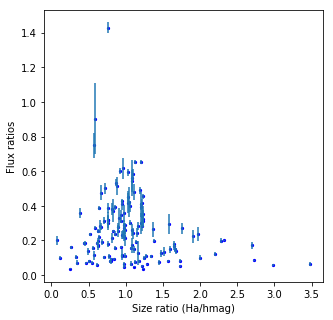

In [1300]:
samp = utils.GTable.read('../complete/final_sample_145.fits')
fig = plt.figure(figsize=[5,5])
ax1 = fig.add_subplot(111)
ax1.scatter(samp['cont_size_kpc'],samp['ratiof'],s=5,c='b')
ax1.scatter(samp['cont_size_kpc'][(samp['agn']==1)],samp['ratiof'][(samp['agn']==1)],s=30,c='b',marker='*')
ax1.errorbar(x = samp['cont_size_kpc'],y = samp['ratiof'],yerr = get_err(linef,err_linef,contf,err_contf),fmt='none')
             
             #yerr = samp['ratiof_err'],fmt='none')
ax1.set_xlabel('Infrared size (kpc)')
ax1.set_ylabel(r'Flux ratios')
#ax1.set_xlim([0.8,25])
#ax1.set_ylim([0.8,25])
#ax1.plot([0,25],[0,25],c='gray',linestyle='dashed')
#ax1.semilogx()
fig.show()

fig = plt.figure(figsize=[5,5])
ax1 = fig.add_subplot(111)
ax1.scatter(samp['ha_line_size_kpc']/samp['cont_size_kpc'],samp['ratiof'],s=5,c='b')
ax1.errorbar(x = samp['ha_line_size_kpc']/samp['cont_size_kpc'],y = samp['ratiof'],yerr = samp['ratiof_err'],fmt='none')
ax1.set_xlabel('Size ratio (Ha/hmag)')
ax1.set_ylabel(r'Flux ratios')
#ax1.set_xlim([0.8,25])
#ax1.set_ylim([0.8,25])
#ax1.plot([0,25],[0,25],c='gray',linestyle='dashed')

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


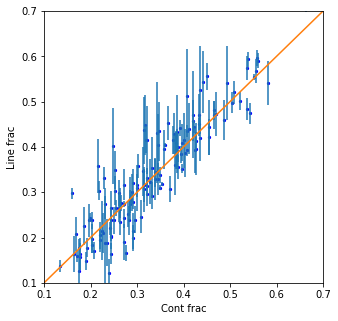

In [1334]:
samp = utils.GTable.read('../complete/final_sample_145.fits')

def get_err(x,xe,y,ye):
    err = ((1./y)*(xe))**2+((x/y**2)*(ye))**2
    return np.sqrt(err)

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
ax.scatter(samp['contf_3kpc']/samp['cont_flux'],samp['linef_3kpc']/(samp['flux_Ha']/(1e-17)),s=5,c='b')
ax.errorbar(samp['contf_3kpc']/samp['cont_flux'],samp['linef_3kpc']/(samp['flux_Ha']/(1e-17)), yerr = get_err(samp['linef_3kpc'],samp['err_linef_3kpc'],(samp['flux_Ha']/1e-17),(samp['err_Ha']/1e-17)),
           fmt='none')
ax.set_xlabel('Cont frac')
ax.set_ylabel('Line frac')
ax.set_xlim([0.1,0.7])
ax.set_ylim([0.1,0.7])
ax.plot([0,1],[0,1])
fig.show()

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


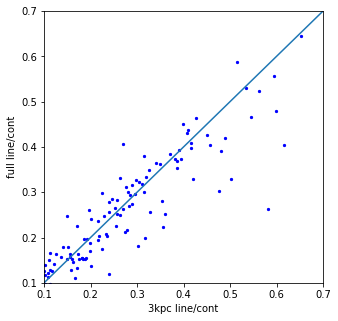

In [1339]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
ax.scatter(samp['linef_3kpc']/samp['contf_3kpc'],(samp['flux_Ha']/(1e-17)-samp['linef_3kpc'])/(samp['cont_flux']-samp['contf_3kpc']),s=5,c='b')
#ax.errorbar(samp['contf_3kpc']/samp['cont_flux'],samp['linef_3kpc']/(samp['flux_Ha']/(1e-17)), yerr = get_err(samp['linef_3kpc'],samp['err_linef_3kpc'],(samp['flux_Ha']/1e-17),(samp['err_Ha']/1e-17)),
           #fmt='none')
ax.set_xlabel('3kpc line/cont')
ax.set_ylabel('full line/cont')
ax.set_xlim([0.1,0.7])
ax.set_ylim([0.1,0.7])
ax.plot([0,1],[0,1])
fig.show()

# Calculate SFR

In [142]:
samp = utils.GTable.read('../complete/final_sample_145.fits')
lower = utils.GTable.read('../complete_10.5/final_sample.fits')

# Get luminosity distance
samp['lum_dist'] = Planck15.luminosity_distance(z=samp['redshift']).to(u.cm).value
lower['lum_dist'] = Planck15.luminosity_distance(z=lower['redshift']).to(u.cm).value

samp['lum_Ha'] = samp['flux_Ha']*4*np.pi*samp['lum_dist']**2
samp['Ha_err'] = samp['err_Ha']*4*np.pi*samp['lum_dist']**2

lower['lum_Ha'] = lower['flux_Ha']*4*np.pi*lower['lum_dist']**2
lower['Ha_err'] = lower['err_Ha']*4*np.pi*lower['lum_dist']**2

# Kennicut
samp['sfr_ken'] = np.log10(samp['lum_Ha']*7.9e-42)
lower['sfr_ken'] = np.log10(lower['lum_Ha']*7.9e-42)

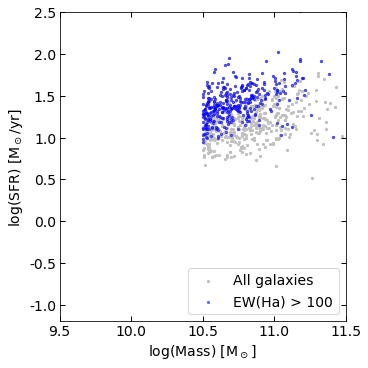

In [219]:
s = (samp['ew50_Ha'] > 100)
ss = lower['ew50_Ha'] > 100

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
ax.scatter(samp['mass'],(samp['sfr_ken']),s=5,c='silver',label=None)
ax.scatter(lower['mass'],(lower['sfr_ken']),s=5,c='silver',label='All galaxies')
ax.scatter(samp['mass'][s],(samp['sfr_ken'][s]),s=5,alpha=0.5,c='blue',label='EW(Ha) > 100')
ax.scatter(lower['mass'][ss],(lower['sfr_ken'][ss]),s=5,alpha=0.5,c='blue',label=None)

#ax.plot([9,11],[0,1.5],c='silver',linestyle='dashed') # line from Nelson 2013
ax.set_xlim([9.5,11.5])
ax.set_ylim([-1.2,2.5])

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel(r'log(Mass) [M$_\odot$]',fontsize=14)
ax.set_ylabel(r'log(SFR) [M$_\odot$/yr]',fontsize=14)
ax.tick_params(which='both',labelsize=14,direction='in',length=5,width=1,top=True,right=True)
ax.legend(fontsize=14,loc='lower right')
fig.tight_layout(pad=0.3)
fig.savefig('../complete/mass_v_sfr.png',dpi=400,overwrite=True,transparent=True)

# Stack!!

- Normaliza by F140W flux
- PSF correction

In [943]:
read = utils.GTable.read('../complete/final_sample_145.fits')
samp = read[(read['redshift'] > 1.1) & (read['redshift'] < 1.3)]

28


/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


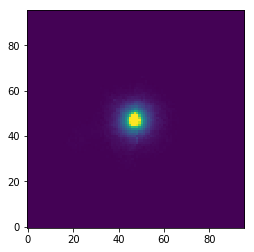

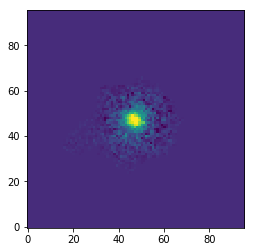

66


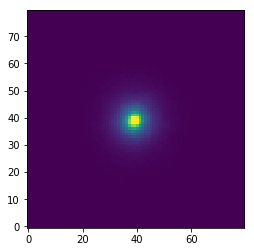

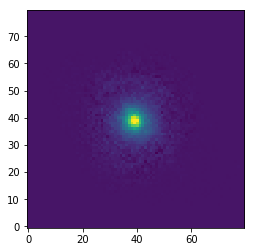

4


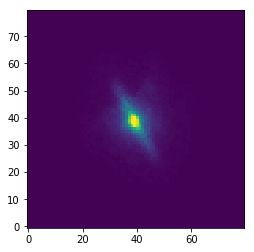

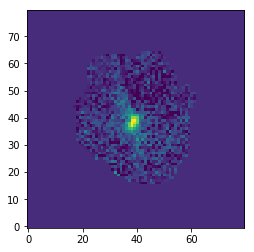

In [1354]:
log_stretch = LogStretch(a=1)

def normalize(image):
        m, M = np.min(image), np.max(image)
        m, M = np.percentile(image,[1,99])
        M *= 4
        m = -0.1*M
        return (image-m) / (M-m)

def stack(samp,figname):
    cont,line,weight_line,weight,psfs,psfs_weight = [],[],[],[],[],[]
    print(len(samp))
    for i,tab in enumerate(samp):
        full = fits.open('../complete/full/{0}_{1:05d}.full.fits'.format(tab['root'],tab['id']))
        filt = full['DSCI'].header['FILTER']
        psf = fits.open('../complete/psfs/{0}-f{1}w_psf.fits'.format(tab['root'],filt[1:4]))[1].data
        #print(psf.shape)
        data = full['DSCI'].data
        data_line = full['LINE','Ha'].data

        segmap = fits.open('../complete/segmap/{0}_{1:05d}.seg.fits'.format(tab['root'],tab['id']))[0].data

        dwht = full['DWHT'].data
        dwht_line = full['LINEWHT','Ha'].data

        err = np.sqrt(1./dwht)
        err_line = np.sqrt(1./dwht_line)

        err[~np.isfinite(err)] = -99
        err_line[~np.isfinite(err_line)] = -99

        mask = (segmap == tab['id']) | (err==-99)
        mask_line = (segmap == tab['id']) | (err_line == -99)

        m0 = np.median(tab['hmag_aliza'])
        norm = 10**(0.4*(tab['hmag_aliza']-m0))
        weight.append(dwht/norm**2)
        weight_line.append(dwht_line/norm**2)

        cont.append(data*mask*weight[i])
        line.append(data_line*mask_line*weight_line[i])
        psfs.append(psf)
        psfs_weight.append(1.)
    
    cont_total_weight = np.maximum(np.sum(weight,axis=0),1)
    line_total_weight = np.maximum(np.sum(weight_line,axis=0),1)
    avg_cont = np.sum(cont,axis=0)/cont_total_weight
    avg_line = np.sum(line,axis=0)/line_total_weight
    psf_stack = sum(psfs)/len(psfs_weight)
    
    hdu_cont = fits.PrimaryHDU(avg_cont)
    hdu_line = fits.ImageHDU(avg_line)
    hdu_cont_wht = fits.ImageHDU(1./np.sqrt(cont_total_weight)) #1/sqrt(wht)
    hdu_line_wht = fits.ImageHDU(1./np.sqrt(line_total_weight))
    hdu_psf = fits.ImageHDU(psf_stack)
    hdu_total = fits.HDUList([hdu_cont,hdu_cont_wht,hdu_line,hdu_line_wht,hdu_psf])

    hdu_total.writeto('../complete/stack/stack_{0}.fits'.format(figname),overwrite=True)
    
    plt.imshow(log_stretch(normalize(avg_cont)),origin='lower')
    plt.show()
    plt.imshow(log_stretch(normalize(avg_line)),origin='lower')  
    plt.show()

z = (samp['redshift']> 0.9) & (samp['redshift']<1.3)
z = (samp['redshift']> 0.7) & (samp['redshift']<1.5)
stack(samp[(samp['cat']=='wisp') & (samp['hmag_filt'] == 'f140w') & z],'wisp_f140w')
#stack(samp[(samp['cat']=='wisp') & (samp['hmag_filt'] == 'f160w') & z],'wisp_f160w')
stack(samp[(samp['cat']!='wisp') & (samp['hmag_filt'] == 'f140w')& z],'notwisp_f140w')
stack(samp[(samp['cat']!='wisp') & (samp['hmag_filt'] == 'f160w')& z],'notwisp_f160w')


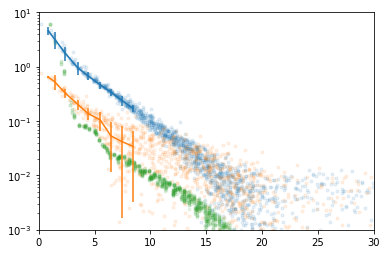

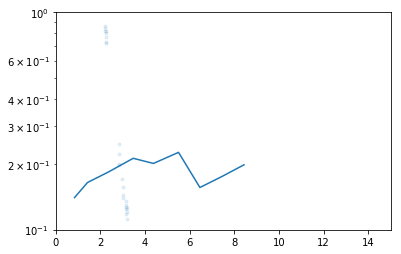

In [1369]:
im = fits.open('../complete/stack/stack_wisp_f140w.fits')

cont = im[0].data
line = im[2].data
psf = im[4].data

#calculate distance of each pixel in image from center
yp,xp = np.indices(im[0].data.shape)
xc = (xp*cont).sum()/cont.sum()
yc = (yp*cont).sum()/cont.sum()
R = np.sqrt((xp-xc)**2+(yp-yc)**2)

#psf centroid
yp_psf,xp_psf = np.indices(im[4].data.shape)
xc_psf = (xp_psf*psf).sum()/psf.sum()
yc_psf = (yp_psf*psf).sum()/psf.sum()
R_psf = np.sqrt((xp_psf-xc_psf)**2+(yp_psf-yc_psf)**2)

xmc,ymc,ysc,n = eazy.utils.running_median(R.flatten(),cont.flatten(),bins=range(10))

plt.scatter(R.flatten(),cont.flatten(),marker='.',alpha=0.1)
plt.errorbar(xmc,ymc,ysc)
plt.scatter(R.flatten(),line.flatten(),marker='.',alpha=0.1)
xml,yml,ysl,n = eazy.utils.running_median(R.flatten(),line.flatten(),bins=range(10))
plt.errorbar(xml,yml,ysl)
plt.scatter(R_psf.flatten(),psf.flatten(),marker='.',alpha=0.1)
plt.semilogy()
plt.ylim(1e-3,10)
plt.xlim(0,30)
plt.show()

plt.scatter(R_psf.flatten(),psf.flatten(),marker='.',alpha=0.1)
plt.plot(xmc,yml/ymc)
plt.semilogy()
plt.ylim(0.1,1)
plt.xlim(0,15)
plt.show()


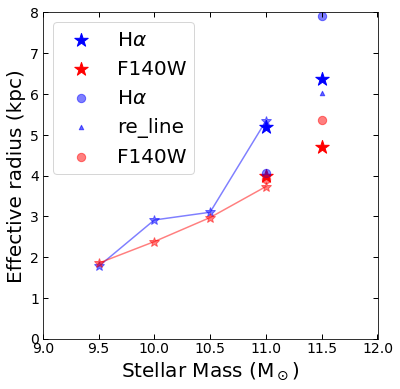

In [66]:
# import stacks and plot
output_table_10= utils.GTable.read('../complete_10.5/stack/output_table.fits')
output_table_11= utils.GTable.read('../complete/stack/output_table.fits')
output_table_10['mass'] = 11
output_table_11['mass'] = 11.5
output_table = vstack([output_table_10,output_table_11])
output_table['re_line'] = output_table['line_rhalf_ellip']*output_table['arc_per_pix']*output_table['kpcperarc']
output_table['re_cont'] = output_table['cont_rhalf_ellip']*output_table['arc_per_pix']*output_table['kpcperarc']


fig = plt.figure(figsize=[6,6])

zmax = output_table['zmax'] == 1.1
wisp = output_table['cat'] == 'wisp'
notwisp = output_table['cat'] == '!wisp'

ax2 = fig.add_subplot(111)

ax2.scatter([11,11.5],[np.average(output_table['re_line'][(output_table['mass'] == 11)&notwisp]),
                               np.average(output_table['re_line'][(output_table['mass'] == 11.5)&notwisp])],
                                color = 'blue',label=r'H$\alpha$',marker = '*',s=200)
ax2.scatter([11,11.5],[np.average(output_table['re_cont'][(output_table['mass'] == 11)&notwisp]),
                               np.average(output_table['re_cont'][(output_table['mass'] == 11.5)&notwisp])],
                                color ='red',label='F140W',marker = '*',s=200)
ax2.scatter([11,11.5],[np.average(output_table['re_line'][(output_table['mass'] == 11)&wisp]),
                               np.average(output_table['re_line'][(output_table['mass'] == 11.5)&wisp])],
                                color = 'blue',label=r'H$\alpha$',marker = 'o',s=70,alpha=0.5)
ax2.scatter(output_table['mass'][wisp & (output_table['mass']>11) & (output_table['zmax']==1.5)],
           output_table['re_line'][wisp & (output_table['mass']>11)& (output_table['zmax']==1.5)],
           color = 'blue',marker = '^',s=20,alpha=0.6)

ax2.scatter([11,11.5],[np.average(output_table['re_cont'][(output_table['mass'] == 11)&wisp]),
                               np.average(output_table['re_cont'][(output_table['mass'] == 11.5)&wisp])],
                                color ='red',label='F140W',marker = 'o',s=70,alpha=0.5)


ax2.set_xlabel(r'Stellar Mass (M$_\odot$)',fontsize=20)
ax2.set_ylabel(r'Effective radius (kpc)',fontsize=20)
ax2.plot([9.5,10,10.5,11],[1.77,2.91,3.10,5.34],marker='*',markersize=10, color='blue',alpha=0.5)
ax2.plot([9.5,10,10.5,11],[1.85,2.38,2.97,3.73],marker='*',markersize=10, color='red',alpha=0.5)
ax2.tick_params(which='both',labelsize=14,direction='in',length=5,width=1,top=True,right=True)
ax2.set_xlim([9,12])
ax2.set_ylim([0,8])
ax2.legend(fontsize=20)

fig.savefig('../complete/result.png',dpi=300,overwrite=True)


/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


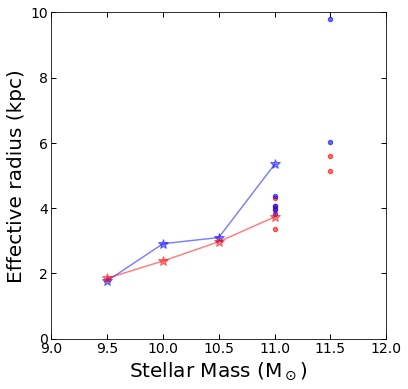

In [71]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
# ax.scatter(output_table['mass'][notwisp],output_table['re_line'][notwisp],
#                                 color = 'blue',marker = '*',s=200,alpha=0.6)
# ax.scatter(output_table['mass'][notwisp],output_table['re_cont'][notwisp],
#                                 color = 'red',marker = '*',s=200,alpha=0.6)
ax.scatter(output_table['mass'][wisp ],output_table['re_cont'][wisp ],
                                 color = 'red',marker = 'o',s=20,alpha=0.6)
ax.scatter(output_table['mass'][wisp ],
           output_table['re_line'][wisp ],
           color = 'blue',marker = 'o',s=20,alpha=0.6)


ax.set_xlabel(r'Stellar Mass (M$_\odot$)',fontsize=20)
ax.set_ylabel(r'Effective radius (kpc)',fontsize=20)
ax.plot([9.5,10,10.5,11],[1.77,2.91,3.10,5.34],marker='*',markersize=10, color='blue',alpha=0.5)
ax.plot([9.5,10,10.5,11],[1.85,2.38,2.97,3.73],marker='*',markersize=10, color='red',alpha=0.5)
ax.tick_params(which='both',labelsize=14,direction='in',length=5,width=1,top=True,right=True)
ax.set_xlim([9,12])
ax.set_ylim([0,10])

fig.show()

In [ ]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (10000,-1))

In [188]:
output_table['re_line'] = output_table['line_rhalf_ellip']*output_table['arc_per_pix']*output_table['kpcperarc']
output_table['re_cont'] = output_table['cont_rhalf_ellip']*output_table['arc_per_pix']*output_table['kpcperarc']

np.average(output_table['re_line'][output_table['mass'] == 11])
np.average(output_table['re_cont'][output_table['mass'] == 11])
np.average(output_table['re_line'][output_table['mass'] == 11.5])
np.average(output_table['re_cont'][output_table['mass'] == 11.5])


3.9507512995857246

In [46]:
output_table

cont_orientation_centroid,line_orientation_centroid,cont_concentration,line_concentration,cont_flag_sersic,line_flag_sersic,cont_gini_m20_bulge,line_gini_m20_bulge,cont_num_badpixels,line_num_badpixels,cont_ymin_stamp,line_ymin_stamp,cont_yc_centroid,line_yc_centroid,cont_rmax_ellip,line_rmax_ellip,cont_sky_median,line_sky_median,cont_sersic_amplitude,line_sersic_amplitude,cont_sersic_theta,line_sersic_theta,cont_multimode,line_multimode,cont_xmin_stamp,line_xmin_stamp,cont_elongation_centroid,line_elongation_centroid,cont_gini,line_gini,cont_label,line_label,cont_sersic_n,line_sersic_n,cont_r20,line_r20,cont_sersic_ellip,line_sersic_ellip,cont_rmax_circ,line_rmax_circ,cont_deviation,line_deviation,cont_ny_stamp,line_ny_stamp,cont_ellipticity_centroid,line_ellipticity_centroid,cont_ellipticity_asymmetry,line_ellipticity_asymmetry,cont_sersic_xc,line_sersic_xc,cont_rpetro_ellip,line_rpetro_ellip,cont_smoothness,line_smoothness,cont_sky_mean,line_sky_mean,cont_xc_asymmetry,line_xc_asymmetry,cont_flux_ellip,line_flux_ellip,cont_shape_asymmetry,line_shape_asymmetry,cont_m20,line_m20,cont_nx_stamp,line_nx_stamp,cont_intensity,line_intensity,cont_r80,line_r80,cont_asymmetry,line_asymmetry,cont_runtime,line_runtime,cont_rpetro_circ,line_rpetro_circ,cont_sky_sigma,line_sky_sigma,cont_sersic_rhalf,line_sersic_rhalf,cont_sn_per_pixel,line_sn_per_pixel,cont_sersic_yc,line_sersic_yc,cont_xmax_stamp,line_xmax_stamp,cont_yc_asymmetry,line_yc_asymmetry,cont_flag,line_flag,cont_elongation_asymmetry,line_elongation_asymmetry,cont_orientation_asymmetry,line_orientation_asymmetry,cont_rhalf_circ,line_rhalf_circ,cont_outer_asymmetry,line_outer_asymmetry,cont_xc_centroid,line_xc_centroid,cont_rhalf_ellip,line_rhalf_ellip,cont_ymax_stamp,line_ymax_stamp,cont_flux_circ,line_flux_circ,zmin,zmax,cat,arc_per_pix,kpcperarc,mass,re_line,re_cont
float64,float64,float64,float64,int64,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,bytes5,float64,float64,float64,float64,float64
0.011427469390361607,-1.3547100009239614,3.234841572243589,3.0878611889585015,0,0,0.21594608072460053,0.1907797340934052,3,1,17,17,47.43065487762959,47.5228828629058,50.479207150049675,19.904024291759782,-0.0006810634,0.0016974447,0.7274370165651052,0.13890439608443098,0.9434647518757552,0.985126728262332,0.0,0.031055900621118012,13,13,1.053008825286054,1.023329822071972,0.5371335135827041,0.5478584666047575,1,1,2.3531828272175512,1.7847134889351717,1.8318868269595896,1.9759293137339229,-0.05073546239936348,-0.2815194503196793,48.850711973913235,19.64592129490505,0.008647055418572774,0.0051580170427125895,66,66,0.05034034284722544,0.022797949955895347,0.05124158474115148,0.022633093596628795,47.681976666384315,47.65080791148656,10.786627942992999,10.90107496095284,0.1997140303921279,0.33474829080343793,-0.0006301866,0.0015756297,47.106183356497056,47.16473123307317,182.72022469746162,30.29846936711295,0.0,0.31103273318590663,-2.0304981074894886,-1.9175762256852182,66,66,0.0,0.016032770620839083,8.125815441054101,8.191126669360893,0.08808343826586858,0.33565963024075335,1.276440143585205,0.6389400959014893,10.516076457263685,10.788767465156305,0.00036677602,0.0003240656,4.090693002015014,3.5920085741909564,0.10963989,0.012466442,47.56032394605474,47.51748779494